# Unsupervised classification of normal/anomalous sounds using an auxiliary task of supervised classification of the sections

To be executed on Google Colab, otherwise the computation time explodes.

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gefleury/datascientest_anomalous_sounds/blob/main/notebooks/ASD_clf_sounds_DL_from_section_clf.ipynb) 

Using only normal sounds from the train set, we train a CNN to learn for each machine type (bearing, valve, gearbox, etc ...)  its section (0, 1, 2). Then, we use this model on the test set (composed of normal and anormal sounds) and we say (roughly) that a sound whose section type is misclassified corresponds to an anormal sound (actually we look for a relevant criterion to classify normal/anormal sounds). We evaluate the method by comparing to the known normal/anormal labels of the sounds in the test set.

In this version, the melspectrograms are loaded from the folder `Features/melspec_313_128/`. Each machine has its folder `fan/`, `valve/` etc... and each audio sample has its own (flattened) melspectrogram stored as a .npy file.

## Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from IPython.display import Image, display

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import Sequence

import os
#import cv2


## Show the gpu infos  
...and change if needed in "Execution" panel

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 11 14:52:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the spectrograms from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DATA_DCASE2022/Features.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


In [ ]:
#Constants
#PATH_FEATURES_FOLDER = './Features/'
PATH_FEATURES_FOLDER = r"/content/Features/"
PATH_MELSPEC_313_128_FOLDER = PATH_FEATURES_FOLDER + 'melspec_313_128/'

## Build selection dataframe

The spectrogram are stored in the folder `Features/melspec_313_128/`. Each machine has its folder `fan/`, `valve/` etc... <br />
Each audio sample has its own mespectrogram flattened stored as a .npy file. So each file is one line of 313*128 = 40064 features.

We first build a dataframe df which gives us all the properties of the files. This will be used to select sounds according to their section, sound_type, etc ...

In [ ]:
def build_selection_dataframe(folder_path):
    list_dict_file = []    # list of dictionnaries for creating DataFrame

    for subdirectory, directory, files in os.walk(folder_path):
    
        #Get label using directory folder name
        label = subdirectory.split('/')[-1]
        
        #Loop through files
        for file in files:
            path_file = subdirectory + '/' + file
            splitted_filename = file.split('_')

            #Append dictionnary to list
            list_dict_file.append({
                'filepath' : path_file,
                'machine' : label,
                'section' : int(splitted_filename[1]),
                'domain_env' : splitted_filename[2],
                'dir' : splitted_filename[3],
                'sound_type' : splitted_filename[4],
                'id' : splitted_filename[5],
                'suffix' : '_'.join(splitted_filename[6:]).split('.npy')[0]  
            })

    return pd.DataFrame(list_dict_file)

In [ ]:
df = build_selection_dataframe(PATH_MELSPEC_313_128_FOLDER)

In [ ]:
#Encoding labels
label_encoder = LabelEncoder()
df['machine_num'] = label_encoder.fit_transform(df['machine'])

dico = {}
for i in range(7):
    dico[label_encoder.inverse_transform([i])[0]] = i
df_machine = pd.DataFrame.from_dict(dico, orient = 'index', columns = ['machine_num'])

df_machine

machine_num
ToyCar              0
ToyTrain            1
bearing             2
fan                 3
gearbox             4
slider              5
valve               6

In [ ]:
df.head()

filepath  machine  section  \
0  /content/Features/melspec_313_128/gearbox/sect...  gearbox        0   
1  /content/Features/melspec_313_128/gearbox/sect...  gearbox        1   
2  /content/Features/melspec_313_128/gearbox/sect...  gearbox        2   
3  /content/Features/melspec_313_128/gearbox/sect...  gearbox        0   
4  /content/Features/melspec_313_128/gearbox/sect...  gearbox        1   

  domain_env    dir sound_type    id    suffix  machine_num  
0     source  train     normal  0385  volt_1.0            4  
1     source  train     normal  0599     wt_50            4  
2     source  train     normal  0834     id_05            4  
3     source  train     normal  0593  volt_1.5            4  
4     source  train     normal  0963    wt_200            4

In [ ]:
df['machine'].value_counts()

gearbox     3600
valve       3600
ToyTrain    3600
ToyCar      3600
slider      3600
fan         3600
bearing     3599
Name: machine, dtype: int64

## Data Generator

Since the datasets are quite big, let's make a data generator.<br/>

In [ ]:
def data_generator(file_list, label_list, batch_size, num_classes = 3, to_fit = True):
    
    #Index used too go over file list 
    index = 0
    
    #Infinite loop
    while True:
        
        #Case we looped over all the files
        if((index + 1) * batch_size >= len(file_list)):
            #Reinit variables for a next round
            index = 0
            
            #Shuffle list to have different batches
            randomize = np.arange(len(file_list))
            np.random.shuffle(randomize)
            file_list = file_list[randomize]
            label_list = label_list[randomize]
            
        #Loop over files from index * batch size to (index + 1) * batch size
        else:
            #Get files paths
            file_chunk = file_list[index*batch_size:(index+1)*batch_size]
            label_chunk = label_list[index*batch_size:(index+1)*batch_size]
            
            #Init data and labels list
            data = []
            labels = []
            
            #Loop over batch files
            for file, label in zip(file_chunk, label_chunk):
                data.append(np.load(file).reshape(128, 313, 1))
                labels.append(tf.keras.utils.to_categorical(label, num_classes=num_classes))
                
            data = np.asarray(data)
            labels = np.asarray(labels)
            if to_fit:
                yield data, labels
            else:
                yield data
            index = index + 1

## Deep learning tools

In [ ]:
#Plot training
def plot_training_diag(history, machine):
    plt.title(machine)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(np.arange(1 , len(history.history['accuracy']) + 1, 1),
            history.history['accuracy'],
            label = 'Training Accuracy',
            color = 'blue')
    plt.plot(np.arange(1 , len(history.history['val_accuracy']) + 1, 1),
            history.history['val_accuracy'], 
            label = 'Validation Accuracy',
            color = 'red')
    plt.legend()
    plt.show()

def fit_and_predict_section(model, machine, source = False):
    print("******* MACHINE = ", machine + "*******")

    # Choose data
    if source:     # we take only data from the source domain
        train_df = df[(df['dir']=='train') & (df['machine']==machine) & (df['domain_env']=='source')]     
        test_df = df[(df['dir']=='test') & (df['machine']==machine) & (df['domain_env']=='source')]      
    else:         # we take data from the source and target domains
        train_df = df[(df['dir']=='train') & (df['machine']==machine)]     
        test_df = df[(df['dir']=='test') & (df['machine']==machine)]       

    train_filepaths = train_df['filepath']             
    test_filepaths = test_df['filepath'] 

    train_labels = train_df['section']       
    test_labels = test_df['section']

    #Separate the train set into train and validation sets
    train_filepaths, valid_filepaths, y_train, y_valid = train_test_split(train_filepaths, \
                                                                          train_labels, test_size=0.2, \
                                                                          stratify = train_labels)
    # Generate datasets from generator
    batch_size = 32
    num_classes = 3

    train_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args= [train_filepaths, y_train, batch_size, num_classes],
        output_types = (tf.float32, tf.float32),
        output_shapes = ((batch_size, 128, 313, 1), (batch_size, num_classes))
    )

    validation_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args= [valid_filepaths, y_valid, batch_size, num_classes],
        output_types = (tf.float32, tf.float32),
        output_shapes = ((batch_size, 128, 313, 1), (batch_size, num_classes))
    )


    # Training
    steps_per_epoch = np.int32(np.ceil(len(train_filepaths)/batch_size))
    validation_steps = np.int32(np.ceil(len(valid_filepaths)/batch_size))

    early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 10, \
                               mode = 'min', restore_best_weights = True, verbose = 1)
    reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 5, \
                                            factor = 0.3, cooldown = 4, verbose = 1)

    training_history = model.fit(train_dataset, validation_data = validation_dataset, steps_per_epoch = steps_per_epoch,
            validation_steps = validation_steps, epochs = 100, callbacks = [early_stopping, reduce_learning_rate])
    

    plot_training_diag(training_history, machine)

    # Get predictions
    batch_size = 1
    to_fit = True   # useless, just for test, can be removed

    test_dataset = tf.data.Dataset.from_generator(
        data_generator,
        args= [test_filepaths, test_labels, batch_size, num_classes, to_fit],
        output_types = (tf.float32, tf.float32),
        output_shapes = ((batch_size, 128, 313, 1), (batch_size, num_classes))
    )

    steps_per_epoch = np.int32(np.floor(len(test_filepaths)/batch_size))
    test_pred = model.predict(test_dataset, steps = steps_per_epoch)

    return test_pred



## Tools to analyze results

In [ ]:
def build_result_df(pred_section_proba, machine, source = False):

    # Choose data
    if source:     # we take only data from the source domain    
        test_df = df[(df['dir']=='test') & (df['machine']==machine) & (df['domain_env']=='source')]      
    else:         # we take data from the source and target domains  
        test_df = df[(df['dir']=='test') & (df['machine']==machine)]       
   
    # Reciprocal function of the sigmoid function
    # To spread input x (between 0 and 1) from ~ -11.5 to 13.8
    def inv_sigmoid(x):      # x is a proba between 0 and 1
        if 0.00001<x and x<0.999999:
            y = np.log(x/(1-x))
        elif x<=0.00001:
             y = np.log(0.00001/(1-0.00001))
        else:
             y = np.log(0.999999/(1-0.999999))
        return y

    y_pred_section = np.argmax(pred_section_proba, axis=1) 
    pred_section_probamax = np.max(pred_section_proba, axis=1) 
    anomaly_scores = [inv_sigmoid(1 - pred_section_probamax[i]) for i in range(len(pred_section_probamax))]
    y_pred_soundtype_proba = 1 - pred_section_probamax

    y_true_section = test_df['section'].values[:len(y_pred_section)]  
    y_true_soundtype = test_df['sound_type'].replace(['normal', 'anomaly'], [0, 1]).values[:len(y_pred_section)]  

    dico = {'anomaly_score': anomaly_scores, 'true_section': y_true_section, \
            'pred_section': y_pred_section, 'true_soundtype': y_true_soundtype, \
            'pred_soundtype_proba':  y_pred_soundtype_proba, 'machine': machine, \
            'domain': test_df['domain_env']}
    data = pd.DataFrame.from_dict(dico)

    return data



In [ ]:
def show_evaluations_section(df_result):
    print("***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** ")
    print("*** MACHINE = ", df_result['machine'].unique()[0] + " ***")
    print(classification_report(df_result['true_section'], df_result['pred_section']))
    display(pd.crosstab(df_result['true_section'], df_result['pred_section'], rownames = ['True'], colnames = ['Pred']))
    print('\n')

In [ ]:
def plot_all_anomaly_scores(df_res):
    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        df_res_mach = df_res[df_res['machine'] == machine]
        fig = plt.figure(figsize = (15, 7))
        ax1 = fig.add_subplot(121)
        ax1.set_title(machine)
        sns.stripplot(data = df_res_mach, x = 'true_section', y = 'anomaly_score', hue = 'true_soundtype', ax = ax1)
        ax2 = fig.add_subplot(122)
        ax2.set_title(machine)
        sns.stripplot(data = df_res_mach, x = 'true_section', y = 'anomaly_score', hue = 'pred_section', ax = ax2)

In [ ]:
def plot_anomaly_acc_vs_threshold(df_res):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        df_res_mach = df_res[df_res['machine'] == machine].copy()

        # Use a threshold on the anomaly score
        accuracies_1 = []
        score_thresholds = np.linspace(-12, 5, 2000)
        for threshold in score_thresholds:
            df_res_mach['pred_soundtype_1'] = df_res_mach['anomaly_score'].apply(lambda score: 1 if score > threshold else 0)
            accuracy = accuracy_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_1'])
            accuracies_1.append(accuracy)

        # Use a threshold on the prediction proba
        accuracies_2 = []
        proba_thresholds = np.linspace(0, 1, 2000)
        for threshold in proba_thresholds:
            df_res_mach['pred_soundtype_2'] = df_res_mach['pred_soundtype_proba'].apply(lambda p: 1 if p > threshold else 0)
            '''
            df_res_mach['pred_soundtype_2'] = df_res_mach.apply(lambda row: 1 if \
                                                                (row['true_section']!=row['pred_section']) \
                                                                & (row['pred_soundtype_proba'] > threshold) \
                                                                else 0, \
                                                                axis = 1)
            '''
            '''
            df_res_mach['pred_soundtype_2'] = df_res_mach.apply(lambda row: 0 if \
                                                                (row['true_section']==row['pred_section']) \
                                                                & (row['pred_soundtype_proba'] < threshold) \
                                                                else 1, \
                                                                axis = 1)
            '''
            accuracy = accuracy_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_2'])
            accuracies_2.append(accuracy)

        # Plot soundtype accuracies vs threshold for all machines
        ax1.plot(score_thresholds, accuracies_1, label = machine)
        ax2.plot(proba_thresholds, accuracies_2, label = machine)

    ax1.legend()
    ax1.set_xlabel("Score threshold")
    ax1.set_ylabel("Accuracy")
    ax2.legend()
    ax2.set_xlabel("Probability threshold")
    ax2.set_ylabel("Accuracy")


 


In [ ]:
def compute_AUCs(df_res):
    dict_aucs = {}
    for machine in ['valve', 'gearbox', 'fan', 'slider', 'bearing', 'ToyCar', 'ToyTrain']:
        df_res_mach = df_res[df_res['machine'] == machine].copy()
        auc = roc_auc_score(df_res_mach['true_soundtype'], df_res_mach['pred_soundtype_proba'])
        dict_aucs[machine] = auc

    # Plot all machine AUCs
    plt.xticks(range(7), dict_aucs.keys())
    plt.ylabel("AUC")
    plt.grid(True, axis = 'y')
    plt.bar(range(7), dict_aucs.values())
    



## RUN : for each machine and both domains, predict the section and deduce the sound type

Choose the model

In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(3, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_83 (Bat  (None, 128, 313, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_61 (Conv2D)          (None, 122, 307, 32)      1600      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 61, 153, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_84 (Bat  (None, 61, 153, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_62 (Conv2D)          (None, 59, 151, 64)       18496     
                                                     

******* MACHINE =  valve*******
Epoch 1/100
75/75 [==============================] - 5s 52ms/step - loss: 0.9750 - accuracy: 0.6496 - val_loss: 33.3763 - val_accuracy: 0.3799 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 3s 46ms/step - loss: 0.2701 - accuracy: 0.9167 - val_loss: 2.0993 - val_accuracy: 0.4112 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 3s 46ms/step - loss: 0.1077 - accuracy: 0.9729 - val_loss: 1.2045 - val_accuracy: 0.5773 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0668 - accuracy: 0.9842 - val_loss: 1.0671 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0424 - accuracy: 0.9892 - val_loss: 1.5183 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0175 - accuracy: 0.9967 - val_loss: 0.6516 - val_accuracy: 0.7928 - lr: 0.0010
Epoch 7/100
75/75 [==================

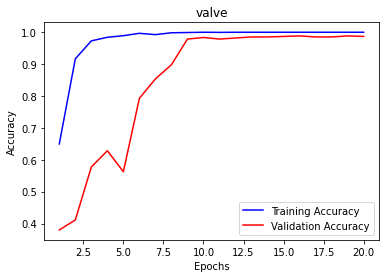

******* MACHINE =  gearbox*******
Epoch 1/100
75/75 [==============================] - 4s 47ms/step - loss: 0.3180 - accuracy: 0.9179 - val_loss: 5.9856 - val_accuracy: 0.3372 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0269 - accuracy: 0.9933 - val_loss: 0.2532 - val_accuracy: 0.9474 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0232 - accuracy: 0.9958 - val_loss: 0.0144 - val_accuracy: 0.9967 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0061 - accuracy: 0.9996 - val_loss: 0.0263 - val_accuracy: 0.9951 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 0.9984 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 0.9984 - lr: 3.0000e-04
Epoch 7/100


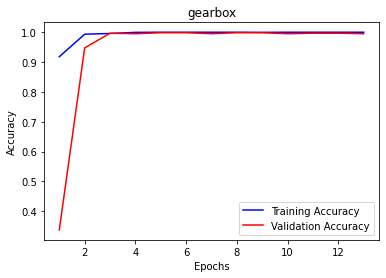

******* MACHINE =  fan*******
Epoch 1/100
75/75 [==============================] - 3s 47ms/step - loss: 0.1060 - accuracy: 0.9621 - val_loss: 0.2091 - val_accuracy: 0.9424 - lr: 9.0000e-05
Epoch 2/100
75/75 [==============================] - 5s 60ms/step - loss: 0.0304 - accuracy: 0.9929 - val_loss: 0.0815 - val_accuracy: 0.9737 - lr: 9.0000e-05
Epoch 3/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0122 - accuracy: 0.9979 - val_loss: 0.0675 - val_accuracy: 0.9803 - lr: 9.0000e-05
Epoch 4/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0107 - accuracy: 0.9979 - val_loss: 0.0222 - val_accuracy: 0.9918 - lr: 9.0000e-05
Epoch 5/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.0113 - val_accuracy: 0.9951 - lr: 9.0000e-05
Epoch 6/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0054 - accuracy: 0.9996 - val_loss: 0.0061 - val_accuracy: 0.9984 - lr: 9.0000e-05
Epoch 7/100
75/7

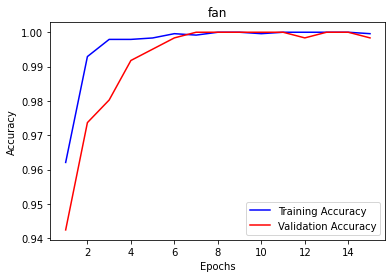

******* MACHINE =  slider*******
Epoch 1/100
75/75 [==============================] - 4s 48ms/step - loss: 0.8412 - accuracy: 0.7912 - val_loss: 0.3656 - val_accuracy: 0.8043 - lr: 2.7000e-05
Epoch 2/100
75/75 [==============================] - 3s 47ms/step - loss: 0.1314 - accuracy: 0.9613 - val_loss: 0.0980 - val_accuracy: 0.9770 - lr: 2.7000e-05
Epoch 3/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0806 - accuracy: 0.9871 - val_loss: 0.0630 - val_accuracy: 0.9901 - lr: 2.7000e-05
Epoch 4/100
75/75 [==============================] - 4s 48ms/step - loss: 0.0612 - accuracy: 0.9883 - val_loss: 0.0530 - val_accuracy: 0.9901 - lr: 2.7000e-05
Epoch 5/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0454 - accuracy: 0.9921 - val_loss: 0.0377 - val_accuracy: 0.9951 - lr: 2.7000e-05
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0363 - accuracy: 0.9929 - val_loss: 0.0285 - val_accuracy: 0.9951 - lr: 2.7000e-05
Epoch 7/100
7

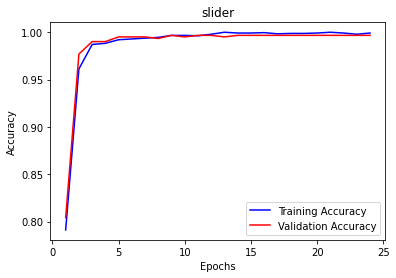

******* MACHINE =  bearing*******
Epoch 1/100
75/75 [==============================] - 5s 61ms/step - loss: 2.5485 - accuracy: 0.3392 - val_loss: 71.3615 - val_accuracy: 0.3257 - lr: 2.4300e-06
Epoch 2/100
75/75 [==============================] - 3s 47ms/step - loss: 1.0657 - accuracy: 0.5771 - val_loss: 2.7583 - val_accuracy: 0.3668 - lr: 2.4300e-06
Epoch 3/100
75/75 [==============================] - 4s 48ms/step - loss: 0.6909 - accuracy: 0.7154 - val_loss: 0.7198 - val_accuracy: 0.6743 - lr: 2.4300e-06
Epoch 4/100
75/75 [==============================] - 5s 65ms/step - loss: 0.5188 - accuracy: 0.8142 - val_loss: 0.4231 - val_accuracy: 0.8586 - lr: 2.4300e-06
Epoch 5/100
75/75 [==============================] - 3s 46ms/step - loss: 0.4085 - accuracy: 0.8675 - val_loss: 0.3255 - val_accuracy: 0.9095 - lr: 2.4300e-06
Epoch 6/100
75/75 [==============================] - 4s 57ms/step - loss: 0.3480 - accuracy: 0.9033 - val_loss: 0.2854 - val_accuracy: 0.9309 - lr: 2.4300e-06
Epoch 7/100

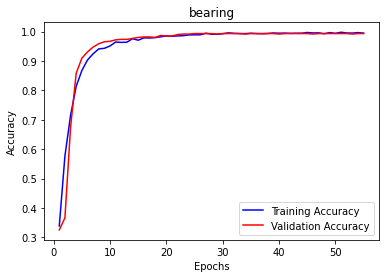

******* MACHINE =  ToyCar*******
Epoch 1/100
75/75 [==============================] - 4s 47ms/step - loss: 2.6106 - accuracy: 0.2104 - val_loss: 420.5836 - val_accuracy: 0.3306 - lr: 2.1870e-07
Epoch 2/100
75/75 [==============================] - 3s 46ms/step - loss: 2.4465 - accuracy: 0.2121 - val_loss: 8.1627 - val_accuracy: 0.3289 - lr: 2.1870e-07
Epoch 3/100
75/75 [==============================] - 3s 46ms/step - loss: 2.3277 - accuracy: 0.2246 - val_loss: 2.5417 - val_accuracy: 0.2632 - lr: 2.1870e-07
Epoch 4/100
75/75 [==============================] - 3s 46ms/step - loss: 2.2272 - accuracy: 0.2296 - val_loss: 2.2111 - val_accuracy: 0.2286 - lr: 2.1870e-07
Epoch 5/100
75/75 [==============================] - 3s 46ms/step - loss: 2.1605 - accuracy: 0.2371 - val_loss: 2.1500 - val_accuracy: 0.2484 - lr: 2.1870e-07
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 2.1135 - accuracy: 0.2392 - val_loss: 2.1740 - val_accuracy: 0.2566 - lr: 2.1870e-07
Epoch 7/100

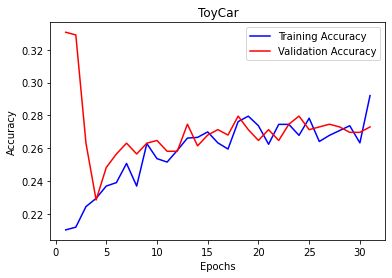

******* MACHINE =  ToyTrain*******
Epoch 1/100
75/75 [==============================] - 4s 47ms/step - loss: 2.4025 - accuracy: 0.3392 - val_loss: 68.6198 - val_accuracy: 0.3109 - lr: 5.9049e-09
Epoch 2/100
75/75 [==============================] - 3s 46ms/step - loss: 2.4488 - accuracy: 0.3338 - val_loss: 7.0385 - val_accuracy: 0.3043 - lr: 5.9049e-09
Epoch 3/100
75/75 [==============================] - 3s 46ms/step - loss: 2.4170 - accuracy: 0.3321 - val_loss: 3.6521 - val_accuracy: 0.3289 - lr: 5.9049e-09
Epoch 4/100
75/75 [==============================] - 3s 46ms/step - loss: 2.4325 - accuracy: 0.3313 - val_loss: 2.9620 - val_accuracy: 0.3158 - lr: 5.9049e-09
Epoch 5/100
75/75 [==============================] - 3s 47ms/step - loss: 2.3974 - accuracy: 0.3354 - val_loss: 2.6955 - val_accuracy: 0.3240 - lr: 5.9049e-09
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 2.4385 - accuracy: 0.3333 - val_loss: 2.6460 - val_accuracy: 0.3289 - lr: 5.9049e-09
Epoch 7/10

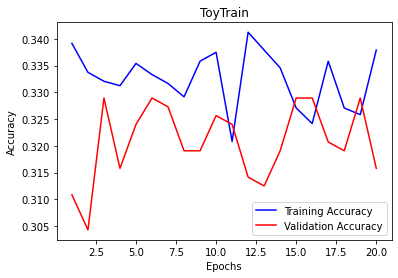

In [ ]:
pred_section_valve = fit_and_predict_section(model, 'valve', source = False)
pred_section_gearbox = fit_and_predict_section(model, 'gearbox', source = False)
pred_section_fan = fit_and_predict_section(model, 'fan', source = False)
pred_section_slider = fit_and_predict_section(model, 'slider', source = False)
pred_section_bearing = fit_and_predict_section(model, 'bearing', source = False)
pred_section_toycar = fit_and_predict_section(model, 'ToyCar', source = False)
pred_section_toytrain = fit_and_predict_section(model, 'ToyTrain', source = False)

In [ ]:
df_result_valve = build_result_df(pred_section_valve, 'valve', source = False)
df_result_gearbox = build_result_df(pred_section_gearbox, 'gearbox', source = False)
df_result_fan = build_result_df(pred_section_fan, 'fan', source = False)
df_result_slider = build_result_df(pred_section_slider, 'slider', source = False)
df_result_bearing = build_result_df(pred_section_bearing, 'bearing', source = False)
df_result_toycar = build_result_df(pred_section_toycar, 'ToyCar', source = False)
df_result_toytrain = build_result_df(pred_section_toytrain, 'ToyTrain', source = False)

df_all_results = pd.concat([df_result_valve, df_result_gearbox, df_result_fan, df_result_slider, \
                            df_result_bearing, df_result_toycar, df_result_toytrain], axis = 0)

df_result_fan.head()

anomaly_score  true_section  pred_section  true_soundtype  \
21603      -3.989947             2             2               0   
21622      -6.177409             2             2               1   
21623      -6.195329             2             2               0   
21633      -7.786177             0             0               0   
21641      -6.118967             0             0               0   

       pred_soundtype_proba machine  domain  
21603              0.018165     fan  target  
21622              0.002071     fan  source  
21623              0.002035     fan  source  
21633              0.000415     fan  source  
21641              0.002196     fan  source

In [ ]:
df_result_fan[df_result_fan['true_section']!=df_result_fan['pred_section']]['domain'].value_counts()

source    21
target    14
Name: domain, dtype: int64

In [ ]:
show_evaluations_section(df_result_valve)
show_evaluations_section(df_result_gearbox)
show_evaluations_section(df_result_fan)
show_evaluations_section(df_result_slider)
show_evaluations_section(df_result_bearing)
show_evaluations_section(df_result_toycar)
show_evaluations_section(df_result_toytrain)

***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  valve ***
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       200
           1       0.70      1.00      0.82       200
           2       0.99      0.71      0.83       200

    accuracy                           0.85       600
   macro avg       0.90      0.85      0.86       600
weighted avg       0.90      0.85      0.86       600



Pred    0    1    2
True               
0     170   28    2
1       0  200    0
2       0   58  142



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  gearbox ***
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       200
           1       0.84      0.95      0.89       200
           2       0.93      0.84      0.88       200

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



Pred    0    1    2
True               
0     188    7    5
1       2  190    8
2       2   30  168



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  fan ***
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       200
           1       0.86      0.99      0.92       200
           2       0.99      0.85      0.92       200

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600



Pred    0    1    2
True               
0     197    3    0
1       1  198    1
2       0   30  170



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  slider ***
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       200
           1       0.96      0.99      0.97       200
           2       0.99      0.90      0.94       200

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600



Pred    0    1    2
True               
0     190    9    1
1       1  198    1
2      21    0  179



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  bearing ***
              precision    recall  f1-score   support

           0       0.45      0.16      0.24       200
           1       0.72      0.81      0.76       200
           2       0.53      0.80      0.64       200

    accuracy                           0.59       600
   macro avg       0.57      0.59      0.54       600
weighted avg       0.57      0.59      0.54       600



Pred   0    1    2
True              
0     32   56  112
1      7  162   31
2     32    8  160



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyCar ***
              precision    recall  f1-score   support

           0       0.23      0.23      0.23       200
           1       0.16      0.12      0.14       200
           2       0.15      0.20      0.17       200

    accuracy                           0.18       600
   macro avg       0.18      0.18      0.18       600
weighted avg       0.18      0.18      0.18       600



Pred    0    1    2
True               
0      45   14  141
1     102   24   74
2      53  108   39



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyTrain ***
              precision    recall  f1-score   support

           0       0.39      0.33      0.36       200
           1       0.28      0.18      0.22       200
           2       0.30      0.45      0.36       200

    accuracy                           0.32       600
   macro avg       0.32      0.32      0.31       600
weighted avg       0.32      0.32      0.31       600



Pred   0   1    2
True             
0     66  32  102
1     51  36  113
2     51  59   90

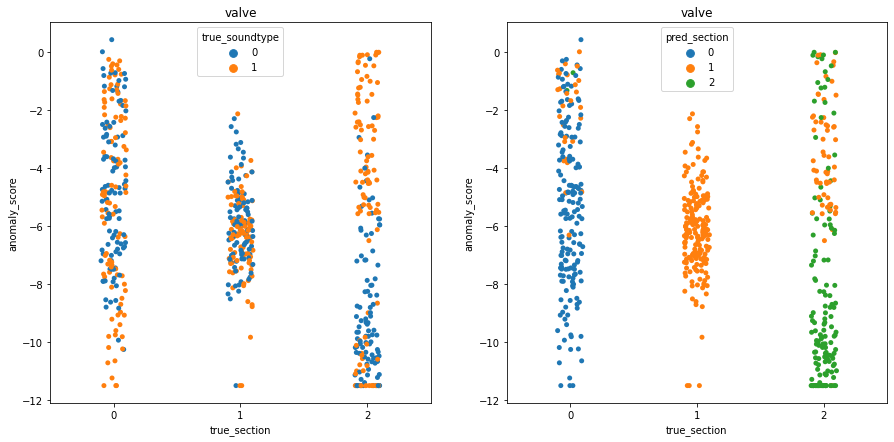

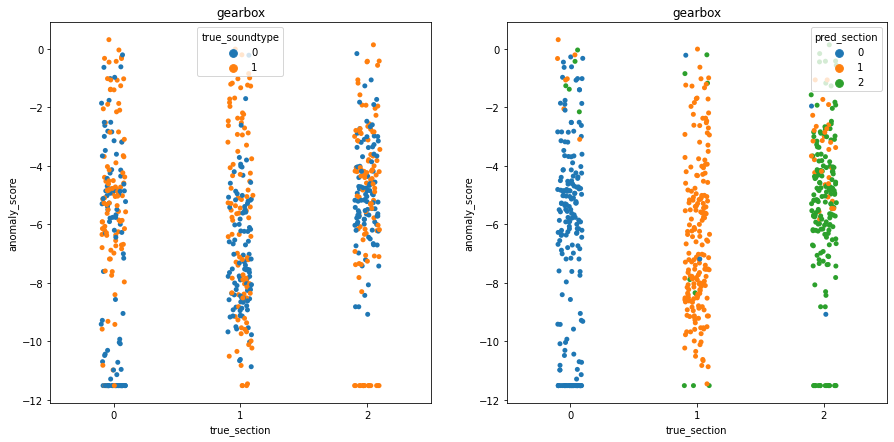

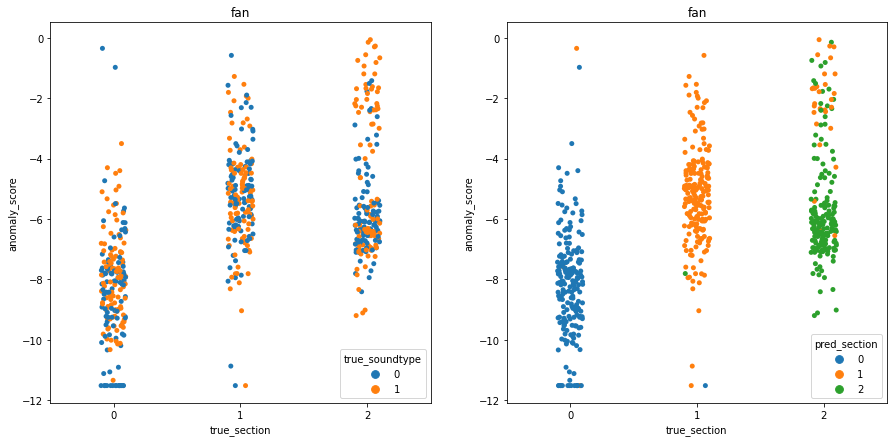

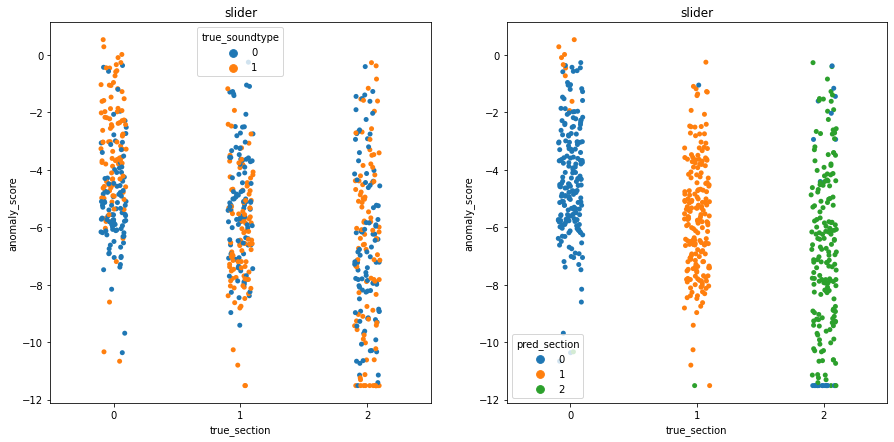

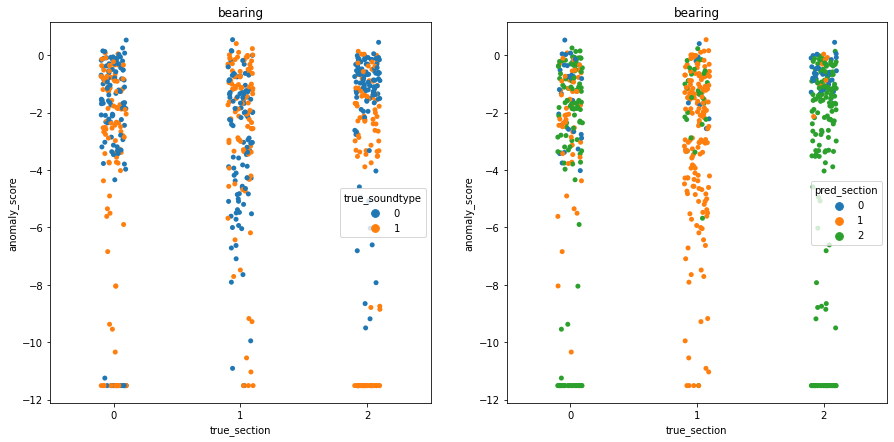

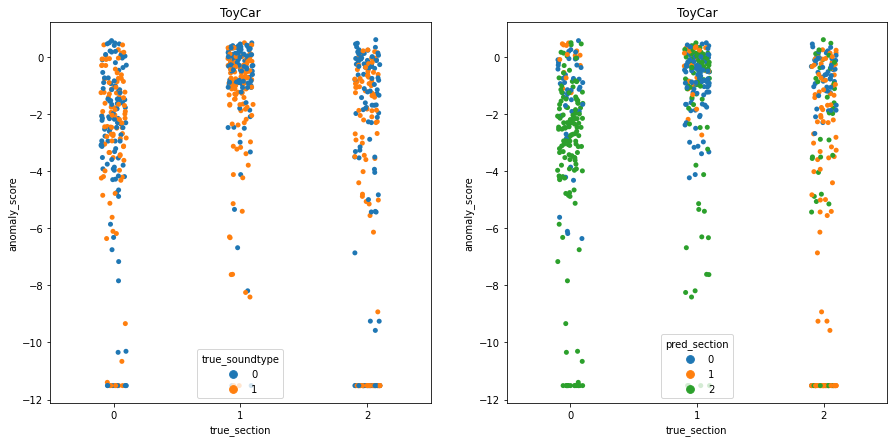

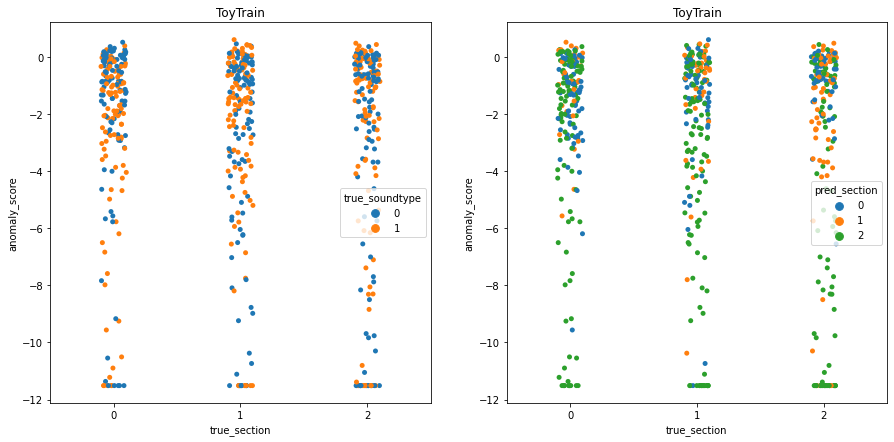

In [ ]:
plot_all_anomaly_scores(df_all_results)

The model is very bad for toycar and toytrain. Also we don't see a clear anomaly score threshold above which there would be only/mainly anormal sounds.

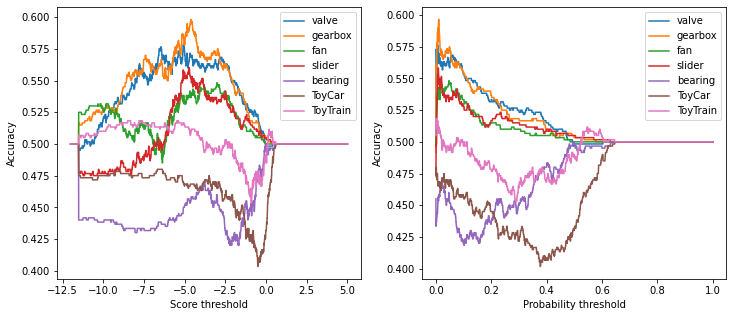

In [ ]:
plot_anomaly_acc_vs_threshold(df_all_results)

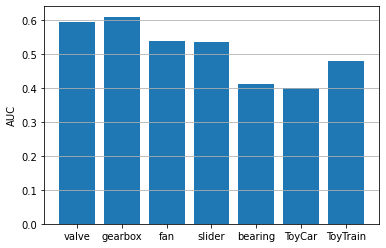

In [ ]:
compute_AUCs(df_all_results)

## Repeat for another model

In [ ]:
# Quentin's model with 3 output classes
model = Sequential(
        [Input(shape = (128, 313, 1), name = "Input"),
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(rate=0.1),
        Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
            Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(rate=0.1),
        Conv2D(filters=128, kernel_size=5, padding='same', activation='relu'),
        Conv2D(filters=64, kernel_size=5, padding='same', activation='relu'),
        Dropout(rate=0.2),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')]
        )

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 128, 313, 32)      320       
                                                                 
 batch_normalization_87 (Bat  (None, 128, 313, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 64, 156, 32)      0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 64, 156, 32)       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 64, 156, 64)       51264     
                                                                 
 conv2d_65 (Conv2D)          (None, 64, 156, 32)     

******* MACHINE =  valve*******
Epoch 1/100
75/75 [==============================] - 8s 88ms/step - loss: 3.1056 - accuracy: 0.7133 - val_loss: 262.0351 - val_accuracy: 0.3372 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 6s 74ms/step - loss: 0.0622 - accuracy: 0.9787 - val_loss: 61.0766 - val_accuracy: 0.3405 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 6s 74ms/step - loss: 0.0248 - accuracy: 0.9929 - val_loss: 1.9297 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 6s 74ms/step - loss: 0.0129 - accuracy: 0.9958 - val_loss: 0.1067 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 5s 73ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 1.8796 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 5s 73ms/step - loss: 0.0380 - accuracy: 0.9871 - val_loss: 0.1013 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 7/100
75/75 [================

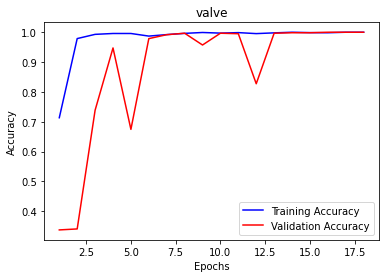

******* MACHINE =  gearbox*******
Epoch 1/100
75/75 [==============================] - 7s 88ms/step - loss: 0.5147 - accuracy: 0.8279 - val_loss: 11.5703 - val_accuracy: 0.4112 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 6s 74ms/step - loss: 0.1494 - accuracy: 0.9454 - val_loss: 0.4317 - val_accuracy: 0.8355 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 6s 74ms/step - loss: 0.0393 - accuracy: 0.9842 - val_loss: 2.5570 - val_accuracy: 0.4934 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 6s 75ms/step - loss: 0.0210 - accuracy: 0.9950 - val_loss: 2.6006 - val_accuracy: 0.4704 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 6s 76ms/step - loss: 0.0141 - accuracy: 0.9946 - val_loss: 0.0896 - val_accuracy: 0.9688 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 6s 73ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.4557 - val_accuracy: 0.8487 - lr: 3.0000e-04
Epoch 7/100

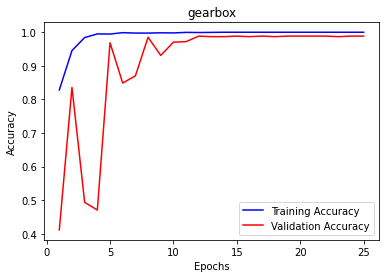

******* MACHINE =  fan*******
Epoch 1/100
75/75 [==============================] - 6s 75ms/step - loss: 0.2144 - accuracy: 0.9488 - val_loss: 5.4561 - val_accuracy: 0.3701 - lr: 2.7000e-05
Epoch 2/100
75/75 [==============================] - 6s 74ms/step - loss: 0.0406 - accuracy: 0.9858 - val_loss: 0.9188 - val_accuracy: 0.6530 - lr: 2.7000e-05
Epoch 3/100
75/75 [==============================] - 6s 74ms/step - loss: 0.0355 - accuracy: 0.9892 - val_loss: 0.1222 - val_accuracy: 0.9622 - lr: 2.7000e-05
Epoch 4/100
75/75 [==============================] - 6s 74ms/step - loss: 0.0298 - accuracy: 0.9925 - val_loss: 0.0472 - val_accuracy: 0.9885 - lr: 2.7000e-05
Epoch 5/100
75/75 [==============================] - 6s 74ms/step - loss: 0.0221 - accuracy: 0.9942 - val_loss: 0.0226 - val_accuracy: 0.9934 - lr: 2.7000e-05
Epoch 6/100
75/75 [==============================] - 6s 75ms/step - loss: 0.0181 - accuracy: 0.9950 - val_loss: 0.0452 - val_accuracy: 0.9836 - lr: 2.7000e-05
Epoch 7/100
75/7

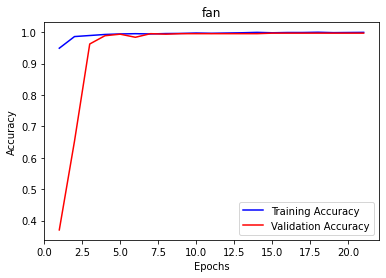

******* MACHINE =  slider*******
Epoch 1/100
75/75 [==============================] - 6s 75ms/step - loss: 3.3179 - accuracy: 0.4279 - val_loss: 3.1512 - val_accuracy: 0.3388 - lr: 2.4300e-06
Epoch 2/100
75/75 [==============================] - 6s 74ms/step - loss: 0.7587 - accuracy: 0.7425 - val_loss: 1.0038 - val_accuracy: 0.6562 - lr: 2.4300e-06
Epoch 3/100
75/75 [==============================] - 6s 81ms/step - loss: 0.4169 - accuracy: 0.8479 - val_loss: 0.4257 - val_accuracy: 0.8520 - lr: 2.4300e-06
Epoch 4/100
75/75 [==============================] - 6s 75ms/step - loss: 0.3237 - accuracy: 0.8808 - val_loss: 0.2697 - val_accuracy: 0.9013 - lr: 2.4300e-06
Epoch 5/100
75/75 [==============================] - 6s 74ms/step - loss: 0.2738 - accuracy: 0.8938 - val_loss: 0.2347 - val_accuracy: 0.9161 - lr: 2.4300e-06
Epoch 6/100
75/75 [==============================] - 6s 74ms/step - loss: 0.2094 - accuracy: 0.9262 - val_loss: 0.1664 - val_accuracy: 0.9309 - lr: 2.4300e-06
Epoch 7/100
7

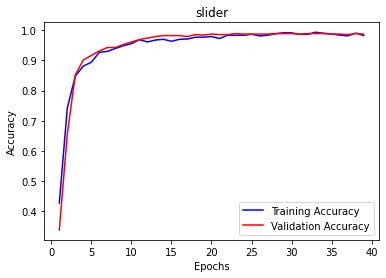

******* MACHINE =  bearing*******
Epoch 1/100
75/75 [==============================] - 6s 75ms/step - loss: 3.7036 - accuracy: 0.2350 - val_loss: 7.0445 - val_accuracy: 0.3322 - lr: 2.1870e-07
Epoch 2/100
75/75 [==============================] - 6s 75ms/step - loss: 2.8673 - accuracy: 0.2629 - val_loss: 4.4888 - val_accuracy: 0.3224 - lr: 2.1870e-07
Epoch 3/100
75/75 [==============================] - 6s 74ms/step - loss: 2.4355 - accuracy: 0.2800 - val_loss: 2.9794 - val_accuracy: 0.2220 - lr: 2.1870e-07
Epoch 4/100
75/75 [==============================] - 6s 74ms/step - loss: 2.1770 - accuracy: 0.3071 - val_loss: 2.2793 - val_accuracy: 0.2780 - lr: 2.1870e-07
Epoch 5/100
75/75 [==============================] - 6s 74ms/step - loss: 1.9955 - accuracy: 0.3117 - val_loss: 1.9991 - val_accuracy: 0.3388 - lr: 2.1870e-07
Epoch 6/100
75/75 [==============================] - 6s 75ms/step - loss: 1.8338 - accuracy: 0.3492 - val_loss: 1.8227 - val_accuracy: 0.3701 - lr: 2.1870e-07
Epoch 7/100


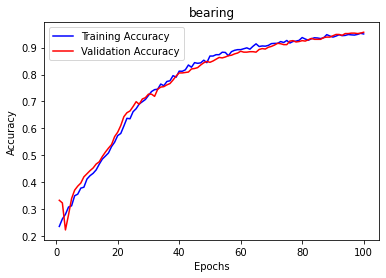

******* MACHINE =  ToyCar*******
Epoch 1/100
75/75 [==============================] - 6s 74ms/step - loss: 3.0039 - accuracy: 0.4062 - val_loss: 6.5665 - val_accuracy: 0.3553 - lr: 2.1870e-07
Epoch 2/100
75/75 [==============================] - 5s 73ms/step - loss: 1.9468 - accuracy: 0.4200 - val_loss: 2.7515 - val_accuracy: 0.4276 - lr: 2.1870e-07
Epoch 3/100
75/75 [==============================] - 6s 73ms/step - loss: 1.6100 - accuracy: 0.4192 - val_loss: 1.7058 - val_accuracy: 0.4326 - lr: 2.1870e-07
Epoch 4/100
75/75 [==============================] - 5s 73ms/step - loss: 1.4432 - accuracy: 0.4263 - val_loss: 1.4397 - val_accuracy: 0.4161 - lr: 2.1870e-07
Epoch 5/100
75/75 [==============================] - 5s 73ms/step - loss: 1.3770 - accuracy: 0.4267 - val_loss: 1.3480 - val_accuracy: 0.4211 - lr: 2.1870e-07
Epoch 6/100
75/75 [==============================] - 5s 73ms/step - loss: 1.3372 - accuracy: 0.4367 - val_loss: 1.3050 - val_accuracy: 0.4145 - lr: 2.1870e-07
Epoch 7/100
7

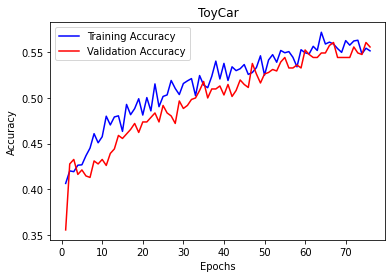

******* MACHINE =  ToyTrain*******
Epoch 1/100
75/75 [==============================] - 6s 74ms/step - loss: 2.7739 - accuracy: 0.3200 - val_loss: 2.3788 - val_accuracy: 0.3520 - lr: 1.9683e-08
Epoch 2/100
75/75 [==============================] - 5s 73ms/step - loss: 2.6590 - accuracy: 0.3221 - val_loss: 2.1849 - val_accuracy: 0.3141 - lr: 1.9683e-08
Epoch 3/100
75/75 [==============================] - 5s 73ms/step - loss: 2.5982 - accuracy: 0.3175 - val_loss: 2.0249 - val_accuracy: 0.3240 - lr: 1.9683e-08
Epoch 4/100
75/75 [==============================] - 5s 73ms/step - loss: 2.5306 - accuracy: 0.3262 - val_loss: 2.1744 - val_accuracy: 0.3043 - lr: 1.9683e-08
Epoch 5/100
75/75 [==============================] - 5s 73ms/step - loss: 2.4741 - accuracy: 0.3204 - val_loss: 2.1914 - val_accuracy: 0.3158 - lr: 1.9683e-08
Epoch 6/100
75/75 [==============================] - 5s 72ms/step - loss: 2.4334 - accuracy: 0.3183 - val_loss: 2.2780 - val_accuracy: 0.3043 - lr: 1.9683e-08
Epoch 7/100

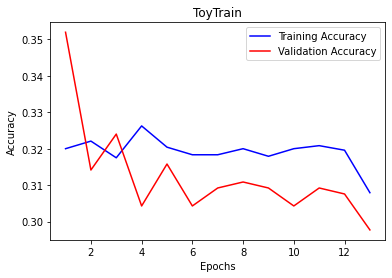

In [ ]:
pred_section_valve = fit_and_predict_section(model, 'valve', source = False)
pred_section_gearbox = fit_and_predict_section(model, 'gearbox', source = False)
pred_section_fan = fit_and_predict_section(model, 'fan', source = False)
pred_section_slider = fit_and_predict_section(model, 'slider', source = False)
pred_section_bearing = fit_and_predict_section(model, 'bearing', source = False)
pred_section_toycar = fit_and_predict_section(model, 'ToyCar', source = False)
pred_section_toytrain = fit_and_predict_section(model, 'ToyTrain', source = False)

In [ ]:
df_result_valve = build_result_df(pred_section_valve, 'valve', source = False)
df_result_gearbox = build_result_df(pred_section_gearbox, 'gearbox', source = False)
df_result_fan = build_result_df(pred_section_fan, 'fan', source = False)
df_result_slider = build_result_df(pred_section_slider, 'slider', source = False)
df_result_bearing = build_result_df(pred_section_bearing, 'bearing', source = False)
df_result_toycar = build_result_df(pred_section_toycar, 'ToyCar', source = False)
df_result_toytrain = build_result_df(pred_section_toytrain, 'ToyTrain', source = False)

df_all_results = pd.concat([df_result_valve, df_result_gearbox, df_result_fan, df_result_slider, \
                            df_result_bearing, df_result_toycar, df_result_toytrain], axis = 0)


In [ ]:
show_evaluations_section(df_result_valve)
show_evaluations_section(df_result_gearbox)
show_evaluations_section(df_result_fan)
show_evaluations_section(df_result_slider)
show_evaluations_section(df_result_bearing)
show_evaluations_section(df_result_toycar)
show_evaluations_section(df_result_toytrain)

***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  valve ***
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       200
           1       0.73      1.00      0.84       200
           2       0.97      0.69      0.80       200

    accuracy                           0.87       600
   macro avg       0.90      0.87      0.87       600
weighted avg       0.90      0.87      0.87       600



Pred    0    1    2
True               
0     184   12    4
1       0  200    0
2       0   63  137



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  gearbox ***
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       200
           1       0.73      0.96      0.83       200
           2       0.97      0.68      0.80       200

    accuracy                           0.86       600
   macro avg       0.89      0.86      0.86       600
weighted avg       0.89      0.86      0.86       600



Pred    0    1    2
True               
0     192    8    0
1       4  192    4
2       2   63  135



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  fan ***
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       0.84      0.98      0.91       200
           2       0.99      0.81      0.89       200

    accuracy                           0.93       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.93      0.93       600



Pred    0    1    2
True               
0     200    0    0
1       2  196    2
2       0   37  163



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  slider ***
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       200
           1       0.94      0.99      0.97       200
           2       0.96      0.99      0.98       200

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



Pred    0    1    2
True               
0     180   12    8
1       2  198    0
2       2    0  198



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  bearing ***
              precision    recall  f1-score   support

           0       0.36      0.21      0.26       200
           1       0.35      0.58      0.43       200
           2       0.21      0.15      0.17       200

    accuracy                           0.32       600
   macro avg       0.30      0.32      0.29       600
weighted avg       0.30      0.32      0.29       600



Pred   0    1   2
True             
0     42  111  47
1     16  117  67
2     59  111  30



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyCar ***
              precision    recall  f1-score   support

           0       0.80      0.68      0.74       200
           1       0.37      0.36      0.36       200
           2       0.40      0.47      0.43       200

    accuracy                           0.50       600
   macro avg       0.52      0.50      0.51       600
weighted avg       0.52      0.50      0.51       600



Pred    0   1    2
True              
0     136  34   30
1      18  72  110
2      16  90   94



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyTrain ***
              precision    recall  f1-score   support

           0       0.37      0.81      0.50       200
           1       0.18      0.11      0.14       200
           2       0.45      0.07      0.11       200

    accuracy                           0.33       600
   macro avg       0.33      0.33      0.25       600
weighted avg       0.33      0.33      0.25       600



Pred    0   1   2
True             
0     163  28   9
1     171  22   7
2     112  75  13

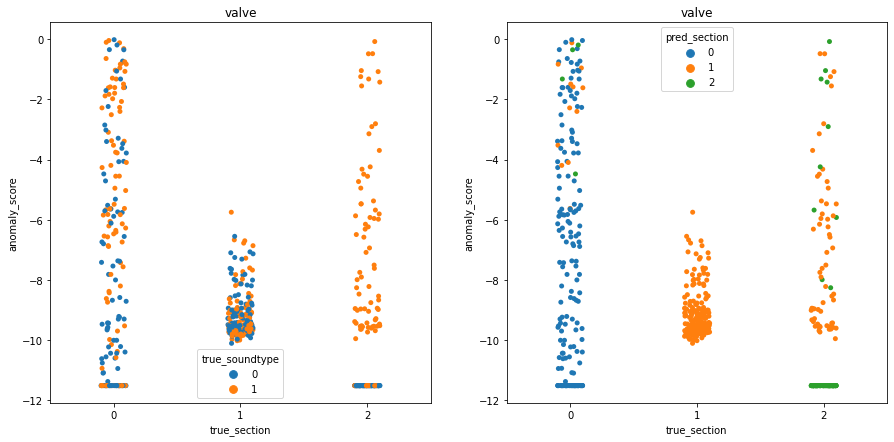

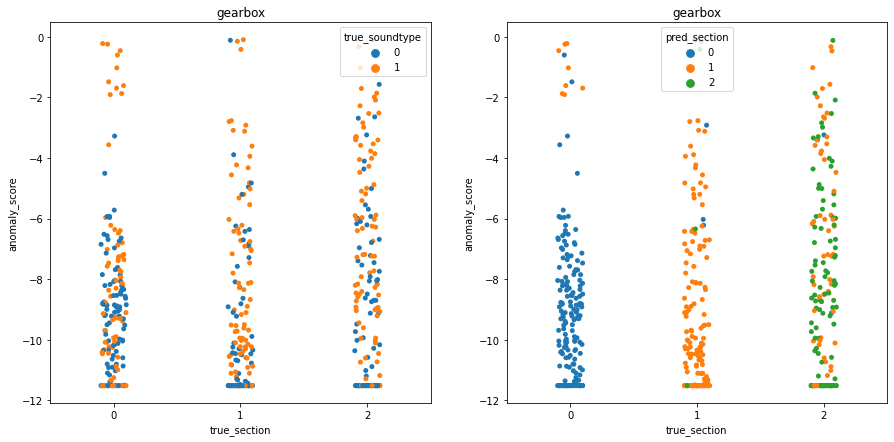

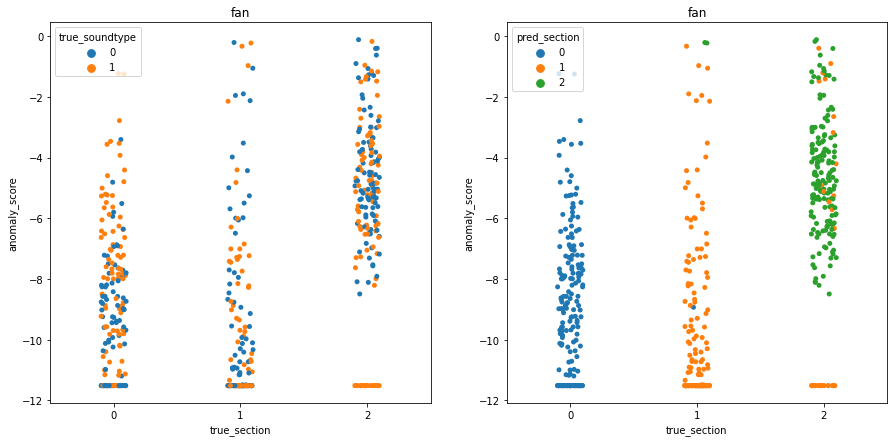

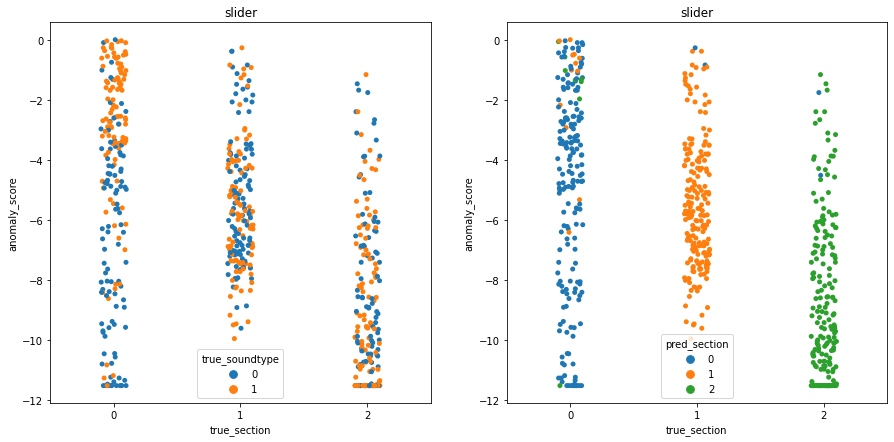

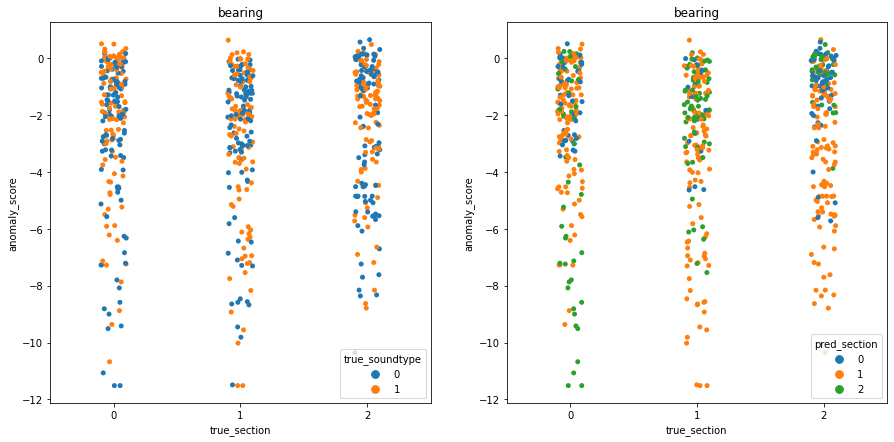

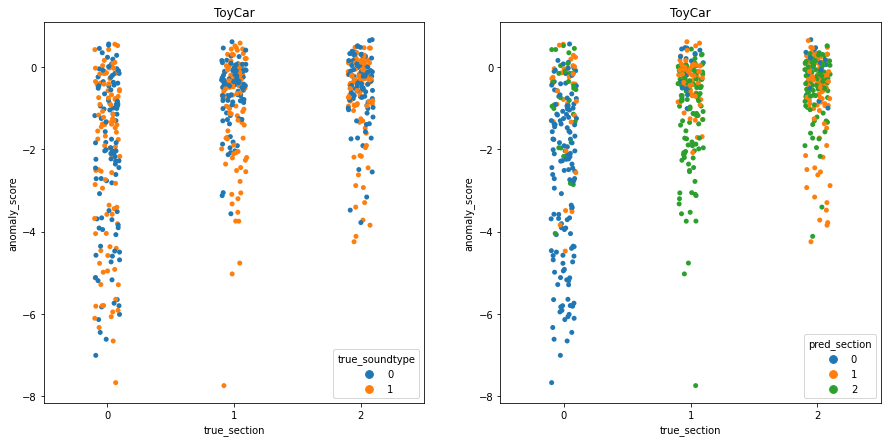

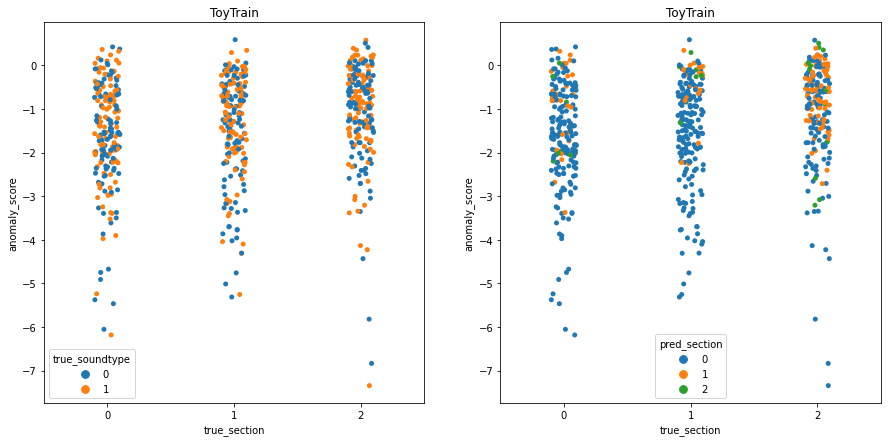

In [ ]:
plot_all_anomaly_scores(df_all_results)

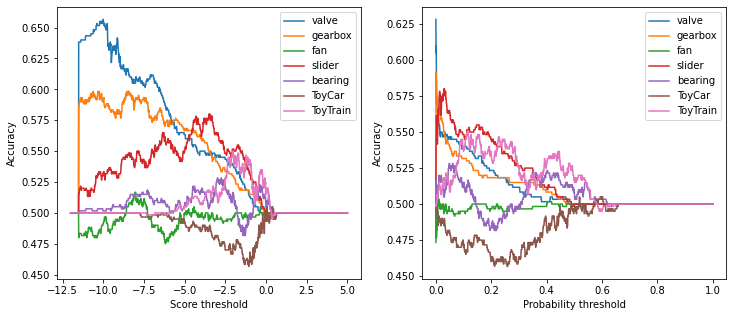

In [ ]:
plot_anomaly_acc_vs_threshold(df_all_results)

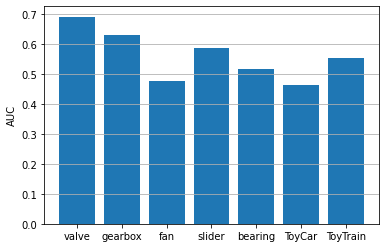

In [ ]:
compute_AUCs(df_all_results)

## Try again with another model

In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(3, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_90 (Bat  (None, 128, 313, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_68 (Conv2D)          (None, 122, 307, 32)      1600      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 61, 153, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_91 (Bat  (None, 61, 153, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_69 (Conv2D)          (None, 59, 151, 64)       18496     
                                                     

******* MACHINE =  valve*******
Epoch 1/100
75/75 [==============================] - 5s 50ms/step - loss: 0.7765 - accuracy: 0.6833 - val_loss: 9.3638 - val_accuracy: 0.3339 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 0.1645 - accuracy: 0.9500 - val_loss: 3.3219 - val_accuracy: 0.3273 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0550 - accuracy: 0.9862 - val_loss: 3.9173 - val_accuracy: 0.4079 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 0.0198 - accuracy: 0.9967 - val_loss: 1.6029 - val_accuracy: 0.4967 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 1.6284 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.2500 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 7/100
75/75 [===================

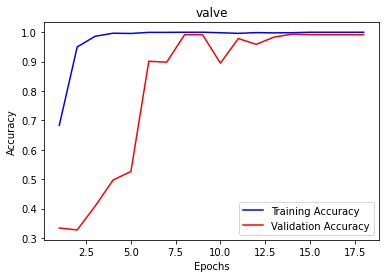

******* MACHINE =  gearbox*******
Epoch 1/100
75/75 [==============================] - 4s 48ms/step - loss: 0.2517 - accuracy: 0.9375 - val_loss: 4.2794 - val_accuracy: 0.4589 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0417 - accuracy: 0.9917 - val_loss: 0.3536 - val_accuracy: 0.8684 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 4s 47ms/step - loss: 0.0137 - accuracy: 0.9971 - val_loss: 0.0224 - val_accuracy: 0.9918 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.0115 - val_accuracy: 0.9967 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.0074 - val_accuracy: 0.9967 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0081 - accuracy: 0.9987 - val_loss: 0.0310 - val_accuracy: 0.9885 - lr: 3.0000e-04
Epoch 7/100


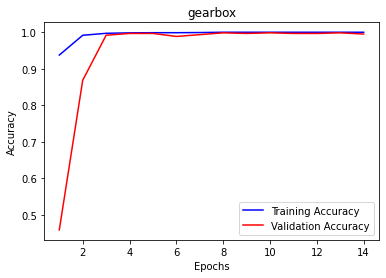

******* MACHINE =  fan*******
Epoch 1/100
75/75 [==============================] - 4s 48ms/step - loss: 0.1423 - accuracy: 0.9592 - val_loss: 0.0969 - val_accuracy: 0.9737 - lr: 9.0000e-05
Epoch 2/100
75/75 [==============================] - 3s 47ms/step - loss: 0.0232 - accuracy: 0.9950 - val_loss: 0.0716 - val_accuracy: 0.9852 - lr: 9.0000e-05
Epoch 3/100
75/75 [==============================] - 3s 47ms/step - loss: 0.0125 - accuracy: 0.9983 - val_loss: 0.0212 - val_accuracy: 0.9934 - lr: 9.0000e-05
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.0092 - val_accuracy: 0.9967 - lr: 9.0000e-05
Epoch 5/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0072 - accuracy: 0.9996 - val_loss: 0.0104 - val_accuracy: 0.9967 - lr: 9.0000e-05
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0047 - accuracy: 0.9992 - val_loss: 0.0064 - val_accuracy: 0.9984 - lr: 9.0000e-05
Epoch 7/100
75/7

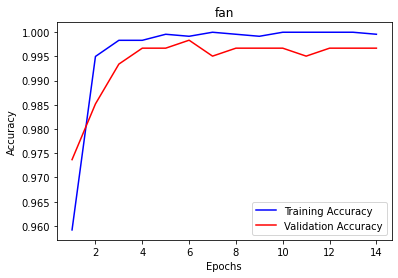

******* MACHINE =  slider*******
Epoch 1/100
75/75 [==============================] - 4s 48ms/step - loss: 0.6995 - accuracy: 0.8183 - val_loss: 0.2421 - val_accuracy: 0.9145 - lr: 2.7000e-05
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 0.1311 - accuracy: 0.9608 - val_loss: 0.1619 - val_accuracy: 0.9556 - lr: 2.7000e-05
Epoch 3/100
75/75 [==============================] - 4s 47ms/step - loss: 0.0812 - accuracy: 0.9800 - val_loss: 0.1044 - val_accuracy: 0.9704 - lr: 2.7000e-05
Epoch 4/100
75/75 [==============================] - 3s 47ms/step - loss: 0.0630 - accuracy: 0.9850 - val_loss: 0.0786 - val_accuracy: 0.9836 - lr: 2.7000e-05
Epoch 5/100
75/75 [==============================] - 4s 47ms/step - loss: 0.0451 - accuracy: 0.9887 - val_loss: 0.0682 - val_accuracy: 0.9918 - lr: 2.7000e-05
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0368 - accuracy: 0.9937 - val_loss: 0.0894 - val_accuracy: 0.9934 - lr: 2.7000e-05
Epoch 7/100
7

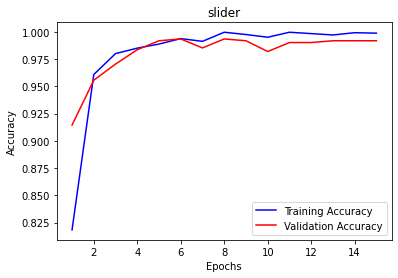

******* MACHINE =  bearing*******
Epoch 1/100
75/75 [==============================] - 4s 49ms/step - loss: 1.1356 - accuracy: 0.6067 - val_loss: 4.0913 - val_accuracy: 0.3257 - lr: 8.1000e-06
Epoch 2/100
75/75 [==============================] - 3s 47ms/step - loss: 0.3486 - accuracy: 0.8883 - val_loss: 0.9179 - val_accuracy: 0.6382 - lr: 8.1000e-06
Epoch 3/100
75/75 [==============================] - 3s 47ms/step - loss: 0.2357 - accuracy: 0.9283 - val_loss: 0.3791 - val_accuracy: 0.8701 - lr: 8.1000e-06
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 0.1852 - accuracy: 0.9588 - val_loss: 0.2122 - val_accuracy: 0.9457 - lr: 8.1000e-06
Epoch 5/100
75/75 [==============================] - 4s 47ms/step - loss: 0.1457 - accuracy: 0.9688 - val_loss: 0.1629 - val_accuracy: 0.9688 - lr: 8.1000e-06
Epoch 6/100
75/75 [==============================] - 4s 47ms/step - loss: 0.1317 - accuracy: 0.9746 - val_loss: 0.1337 - val_accuracy: 0.9770 - lr: 8.1000e-06
Epoch 7/100


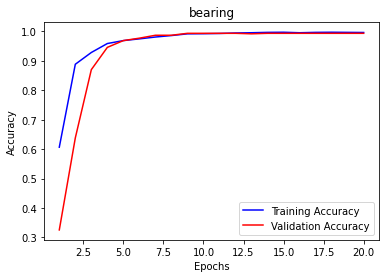

******* MACHINE =  ToyCar*******
Epoch 1/100
75/75 [==============================] - 4s 48ms/step - loss: 1.7839 - accuracy: 0.2713 - val_loss: 60.8908 - val_accuracy: 0.3355 - lr: 2.4300e-06
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 1.3173 - accuracy: 0.3721 - val_loss: 7.2837 - val_accuracy: 0.3618 - lr: 2.4300e-06
Epoch 3/100
75/75 [==============================] - 3s 47ms/step - loss: 1.1746 - accuracy: 0.4408 - val_loss: 1.6950 - val_accuracy: 0.4095 - lr: 2.4300e-06
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 1.0874 - accuracy: 0.4846 - val_loss: 1.3065 - val_accuracy: 0.4276 - lr: 2.4300e-06
Epoch 5/100
75/75 [==============================] - 4s 47ms/step - loss: 1.0369 - accuracy: 0.5117 - val_loss: 1.1830 - val_accuracy: 0.4441 - lr: 2.4300e-06
Epoch 6/100
75/75 [==============================] - 4s 47ms/step - loss: 0.9813 - accuracy: 0.5371 - val_loss: 1.1352 - val_accuracy: 0.4786 - lr: 2.4300e-06
Epoch 7/100


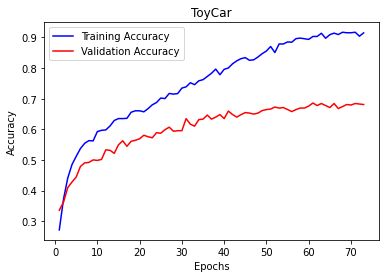

******* MACHINE =  ToyTrain*******
Epoch 1/100
75/75 [==============================] - 4s 48ms/step - loss: 2.1904 - accuracy: 0.3204 - val_loss: 10.9312 - val_accuracy: 0.3109 - lr: 2.1870e-07
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 2.1398 - accuracy: 0.3246 - val_loss: 4.4606 - val_accuracy: 0.3273 - lr: 2.1870e-07
Epoch 3/100
75/75 [==============================] - 4s 47ms/step - loss: 2.0779 - accuracy: 0.3271 - val_loss: 3.2310 - val_accuracy: 0.3306 - lr: 2.1870e-07
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 2.0614 - accuracy: 0.3233 - val_loss: 3.0534 - val_accuracy: 0.3355 - lr: 2.1870e-07
Epoch 5/100
75/75 [==============================] - 4s 47ms/step - loss: 1.9928 - accuracy: 0.3358 - val_loss: 2.7388 - val_accuracy: 0.3421 - lr: 2.1870e-07
Epoch 6/100
75/75 [==============================] - 3s 45ms/step - loss: 1.9546 - accuracy: 0.3379 - val_loss: 2.8441 - val_accuracy: 0.3289 - lr: 2.1870e-07
Epoch 7/10

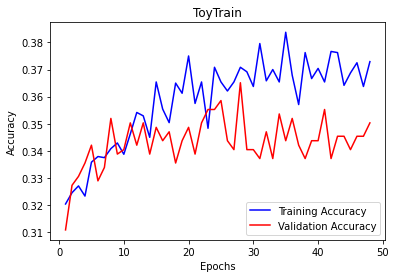

In [ ]:
pred_section_valve = fit_and_predict_section(model, 'valve', source = False)
pred_section_gearbox = fit_and_predict_section(model, 'gearbox', source = False)
pred_section_fan = fit_and_predict_section(model, 'fan', source = False)
pred_section_slider = fit_and_predict_section(model, 'slider', source = False)
pred_section_bearing = fit_and_predict_section(model, 'bearing', source = False)
pred_section_toycar = fit_and_predict_section(model, 'ToyCar', source = False)
pred_section_toytrain = fit_and_predict_section(model, 'ToyTrain', source = False)

In [ ]:
df_result_valve = build_result_df(pred_section_valve, 'valve', source = False)
df_result_gearbox = build_result_df(pred_section_gearbox, 'gearbox', source = False)
df_result_fan = build_result_df(pred_section_fan, 'fan', source = False)
df_result_slider = build_result_df(pred_section_slider, 'slider', source = False)
df_result_bearing = build_result_df(pred_section_bearing, 'bearing', source = False)
df_result_toycar = build_result_df(pred_section_toycar, 'ToyCar', source = False)
df_result_toytrain = build_result_df(pred_section_toytrain, 'ToyTrain', source = False)

df_all_results = pd.concat([df_result_valve, df_result_gearbox, df_result_fan, df_result_slider, \
                            df_result_bearing, df_result_toycar, df_result_toytrain], axis = 0)


In [ ]:
show_evaluations_section(df_result_valve)
show_evaluations_section(df_result_gearbox)
show_evaluations_section(df_result_fan)
show_evaluations_section(df_result_slider)
show_evaluations_section(df_result_bearing)
show_evaluations_section(df_result_toycar)
show_evaluations_section(df_result_toytrain)

***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  valve ***
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       200
           1       0.71      1.00      0.83       200
           2       1.00      0.66      0.80       200

    accuracy                           0.87       600
   macro avg       0.90      0.87      0.87       600
weighted avg       0.90      0.87      0.87       600



Pred    0    1    2
True               
0     188   12    0
1       0  200    0
2       0   68  132



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  gearbox ***
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.78      0.94      0.85       200
           2       0.96      0.76      0.84       200

    accuracy                           0.89       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.89      0.89       600



Pred    0    1    2
True               
0     193    7    0
1       5  188    7
2       2   47  151



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  fan ***
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.86      0.99      0.92       200
           2       1.00      0.84      0.91       200

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600



Pred    0    1    2
True               
0     200    0    0
1       1  199    0
2       0   32  168



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  slider ***
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       200
           1       0.97      0.98      0.98       200
           2       0.98      0.98      0.98       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



Pred    0    1    2
True               
0     189    7    4
1       3  197    0
2       3    0  197



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  bearing ***
              precision    recall  f1-score   support

           0       0.68      0.09      0.15       200
           1       0.61      0.73      0.67       200
           2       0.59      0.98      0.74       200

    accuracy                           0.60       600
   macro avg       0.63      0.60      0.52       600
weighted avg       0.63      0.60      0.52       600



Pred   0    1    2
True              
0     17   93   90
1      6  147   47
2      2    1  197



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyCar ***
              precision    recall  f1-score   support

           0       0.53      0.74      0.62       200
           1       0.45      0.35      0.40       200
           2       0.36      0.29      0.32       200

    accuracy                           0.46       600
   macro avg       0.45      0.46      0.45       600
weighted avg       0.45      0.46      0.45       600



Pred    0   1   2
True             
0     149  19  32
1      60  71  69
2      74  68  58



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyTrain ***
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       200
           1       0.27      0.28      0.27       200
           2       0.37      0.40      0.38       200

    accuracy                           0.37       600
   macro avg       0.38      0.37      0.37       600
weighted avg       0.38      0.37      0.37       600



Pred   0   1   2
True            
0     88  57  55
1     62  55  83
2     29  91  80

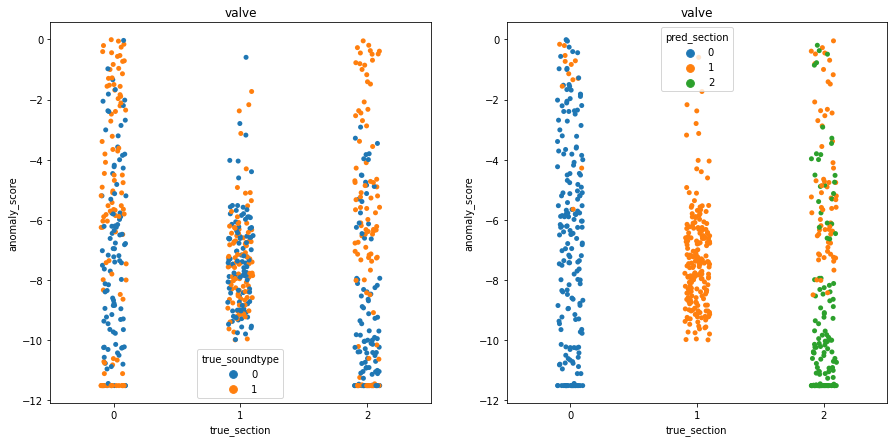

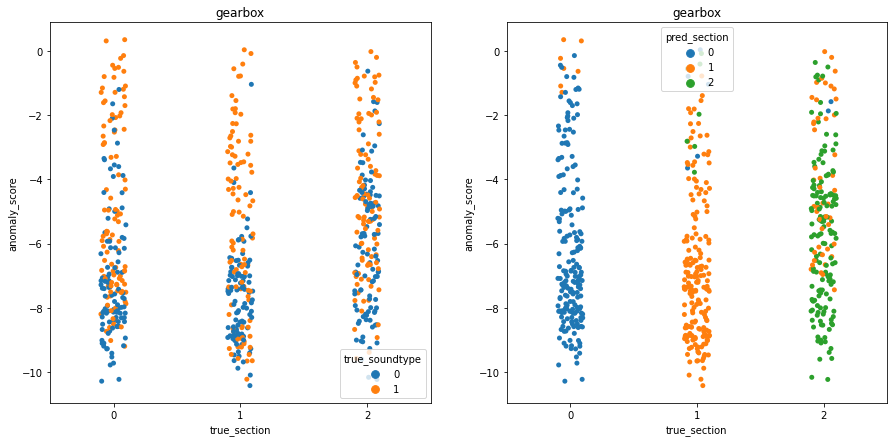

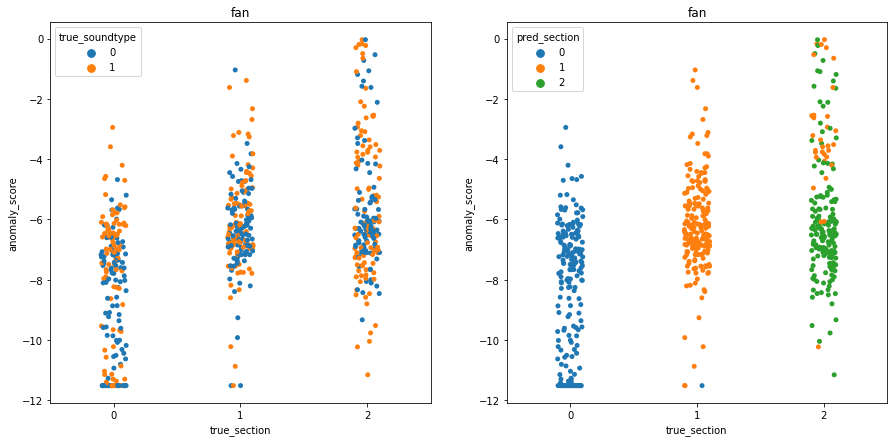

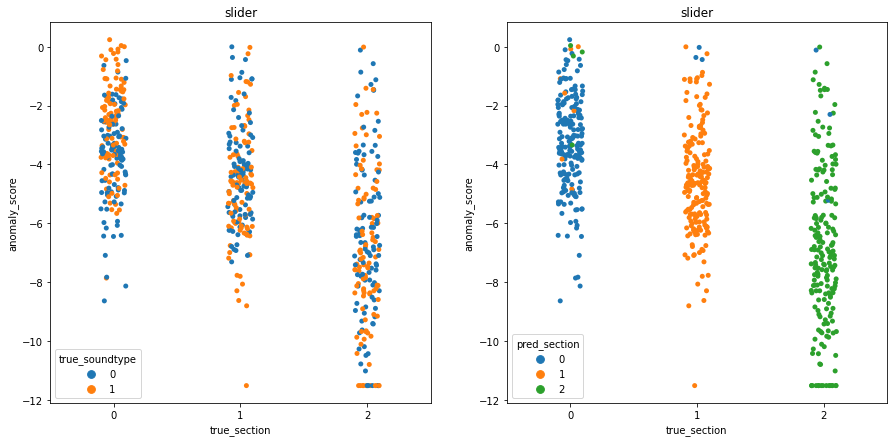

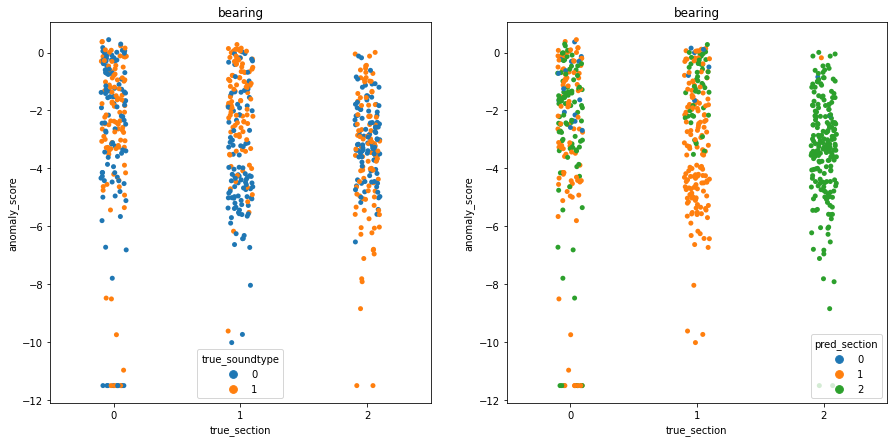

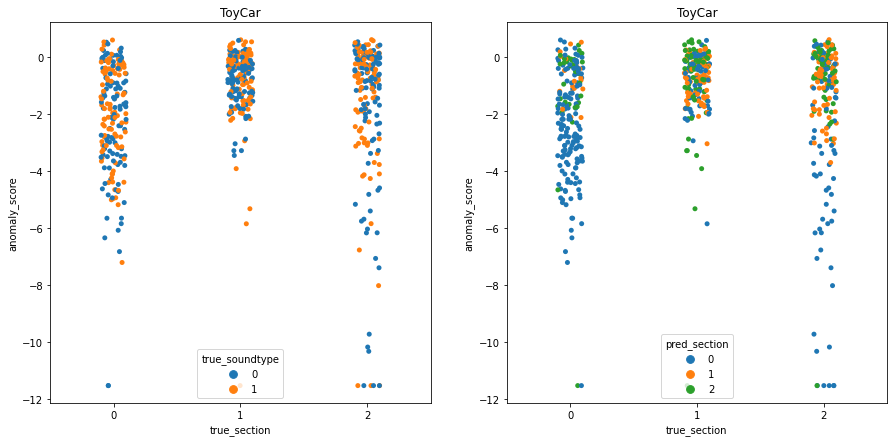

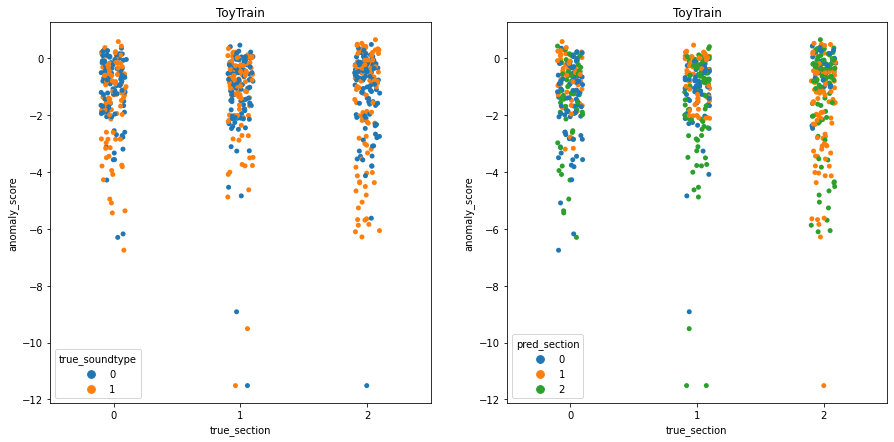

In [ ]:
plot_all_anomaly_scores(df_all_results)

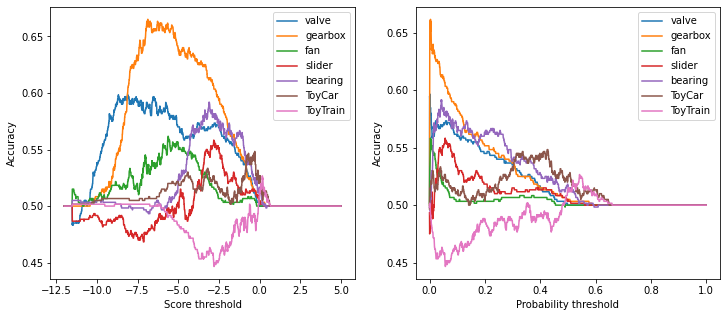

In [ ]:
plot_anomaly_acc_vs_threshold(df_all_results)

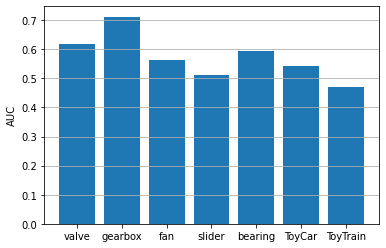

In [ ]:
compute_AUCs(df_all_results)

## Try with the original simplest model which worked well

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu'),
        BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(3, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 313, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 124, 309, 32)      832       
                                                                 
 batch_normalization_1 (Batc  (None, 124, 309, 32)     128       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 1226112)           0         
                                                                 
 dense (Dense)               (None, 128)               156942464 
                                                                 
 batch_normalization_2 (Batc  (None, 128)              5

******* MACHINE =  valve*******
Epoch 1/100
75/75 [==============================] - 20s 90ms/step - loss: 1.5241 - accuracy: 0.4021 - val_loss: 987.6935 - val_accuracy: 0.3322 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 5s 68ms/step - loss: 0.8543 - accuracy: 0.6625 - val_loss: 3.8995 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 5s 72ms/step - loss: 0.4617 - accuracy: 0.8729 - val_loss: 2.9396 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 5s 68ms/step - loss: 0.1749 - accuracy: 0.9742 - val_loss: 2.1804 - val_accuracy: 0.3684 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 5s 67ms/step - loss: 0.0768 - accuracy: 0.9896 - val_loss: 1.7551 - val_accuracy: 0.4622 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 5s 68ms/step - loss: 0.0431 - accuracy: 0.9946 - val_loss: 1.0678 - val_accuracy: 0.6398 - lr: 0.0010
Epoch 7/100
75/75 [================

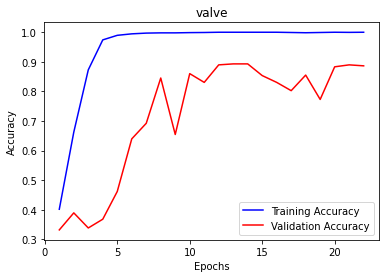

******* MACHINE =  gearbox*******
Epoch 1/100
75/75 [==============================] - 11s 152ms/step - loss: 0.4570 - accuracy: 0.8700 - val_loss: 2.5096 - val_accuracy: 0.5510 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 5s 68ms/step - loss: 0.0450 - accuracy: 0.9917 - val_loss: 0.3239 - val_accuracy: 0.8750 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 5s 67ms/step - loss: 0.0181 - accuracy: 0.9983 - val_loss: 0.0501 - val_accuracy: 0.9901 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 5s 67ms/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0330 - val_accuracy: 0.9918 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 5s 62ms/step - loss: 0.0082 - accuracy: 0.9987 - val_loss: 0.0334 - val_accuracy: 0.9918 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0073 - accuracy: 0.9992 - val_loss: 0.0261 - val_accuracy: 0.9918 - lr: 3.0000e-04
Epoch 7/10

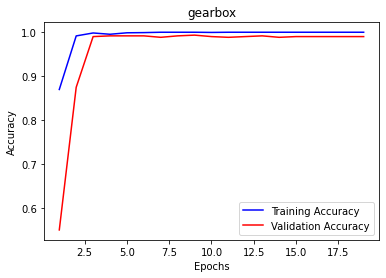

******* MACHINE =  fan*******
Epoch 1/100
75/75 [==============================] - 11s 141ms/step - loss: 0.1612 - accuracy: 0.9517 - val_loss: 0.0462 - val_accuracy: 0.9819 - lr: 9.0000e-05
Epoch 2/100
75/75 [==============================] - 5s 69ms/step - loss: 0.0277 - accuracy: 0.9946 - val_loss: 0.0237 - val_accuracy: 0.9951 - lr: 9.0000e-05
Epoch 3/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0150 - accuracy: 0.9979 - val_loss: 0.0168 - val_accuracy: 0.9967 - lr: 9.0000e-05
Epoch 4/100
75/75 [==============================] - 5s 68ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0127 - val_accuracy: 0.9984 - lr: 9.0000e-05
Epoch 5/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0086 - accuracy: 0.9992 - val_loss: 0.0125 - val_accuracy: 0.9967 - lr: 9.0000e-05
Epoch 6/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.0089 - val_accuracy: 0.9984 - lr: 9.0000e-05
Epoch 7/100
75

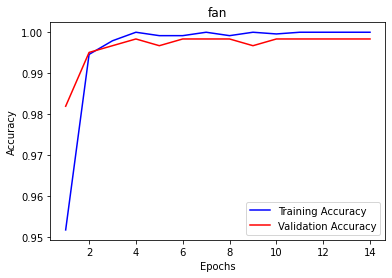

******* MACHINE =  slider*******
Epoch 1/100
75/75 [==============================] - 11s 147ms/step - loss: 0.9212 - accuracy: 0.7633 - val_loss: 0.3508 - val_accuracy: 0.8997 - lr: 2.7000e-05
Epoch 2/100
75/75 [==============================] - 5s 69ms/step - loss: 0.2288 - accuracy: 0.9408 - val_loss: 0.1961 - val_accuracy: 0.9523 - lr: 2.7000e-05
Epoch 3/100
75/75 [==============================] - 5s 68ms/step - loss: 0.1586 - accuracy: 0.9629 - val_loss: 0.1287 - val_accuracy: 0.9688 - lr: 2.7000e-05
Epoch 4/100
75/75 [==============================] - 5s 70ms/step - loss: 0.1016 - accuracy: 0.9775 - val_loss: 0.0871 - val_accuracy: 0.9803 - lr: 2.7000e-05
Epoch 5/100
75/75 [==============================] - 5s 68ms/step - loss: 0.0896 - accuracy: 0.9808 - val_loss: 0.0681 - val_accuracy: 0.9819 - lr: 2.7000e-05
Epoch 6/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0641 - accuracy: 0.9883 - val_loss: 0.0615 - val_accuracy: 0.9836 - lr: 2.7000e-05
Epoch 7/100

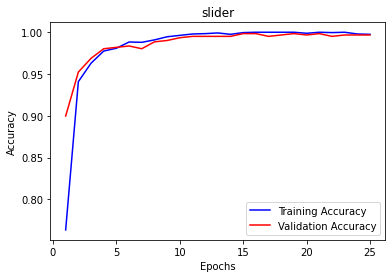

******* MACHINE =  bearing*******
Epoch 1/100
75/75 [==============================] - 11s 140ms/step - loss: 1.1092 - accuracy: 0.6483 - val_loss: 64.3193 - val_accuracy: 0.3405 - lr: 8.1000e-06
Epoch 2/100
75/75 [==============================] - 5s 70ms/step - loss: 0.2403 - accuracy: 0.9454 - val_loss: 1.7200 - val_accuracy: 0.5757 - lr: 8.1000e-06
Epoch 3/100
75/75 [==============================] - 5s 68ms/step - loss: 0.1329 - accuracy: 0.9775 - val_loss: 0.2173 - val_accuracy: 0.9342 - lr: 8.1000e-06
Epoch 4/100
75/75 [==============================] - 5s 67ms/step - loss: 0.1031 - accuracy: 0.9846 - val_loss: 0.1062 - val_accuracy: 0.9737 - lr: 8.1000e-06
Epoch 5/100
75/75 [==============================] - 5s 68ms/step - loss: 0.0811 - accuracy: 0.9929 - val_loss: 0.0826 - val_accuracy: 0.9836 - lr: 8.1000e-06
Epoch 6/100
75/75 [==============================] - 5s 68ms/step - loss: 0.0622 - accuracy: 0.9921 - val_loss: 0.0657 - val_accuracy: 0.9868 - lr: 8.1000e-06
Epoch 7/1

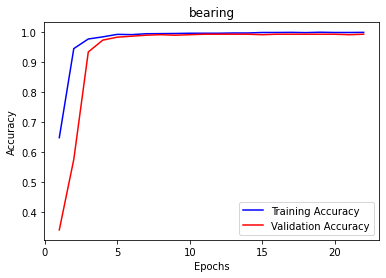

******* MACHINE =  ToyCar*******
Epoch 1/100
75/75 [==============================] - 10s 137ms/step - loss: 1.6690 - accuracy: 0.3633 - val_loss: 36.0832 - val_accuracy: 0.2747 - lr: 2.4300e-06
Epoch 2/100
75/75 [==============================] - 5s 67ms/step - loss: 1.1105 - accuracy: 0.5113 - val_loss: 3.3063 - val_accuracy: 0.4671 - lr: 2.4300e-06
Epoch 3/100
75/75 [==============================] - 5s 67ms/step - loss: 0.9622 - accuracy: 0.5583 - val_loss: 0.9796 - val_accuracy: 0.5312 - lr: 2.4300e-06
Epoch 4/100
75/75 [==============================] - 5s 66ms/step - loss: 0.8946 - accuracy: 0.5854 - val_loss: 0.9573 - val_accuracy: 0.5411 - lr: 2.4300e-06
Epoch 5/100
75/75 [==============================] - 5s 62ms/step - loss: 0.8421 - accuracy: 0.6112 - val_loss: 0.9553 - val_accuracy: 0.5411 - lr: 2.4300e-06
Epoch 6/100
75/75 [==============================] - 5s 67ms/step - loss: 0.7968 - accuracy: 0.6296 - val_loss: 0.9275 - val_accuracy: 0.5526 - lr: 2.4300e-06
Epoch 7/10

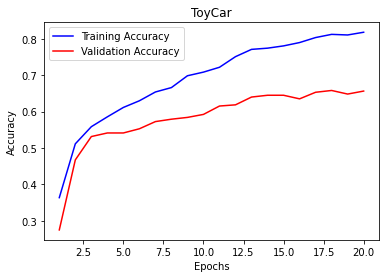

******* MACHINE =  ToyTrain*******
Epoch 1/100
75/75 [==============================] - 11s 141ms/step - loss: 2.4143 - accuracy: 0.3342 - val_loss: 13.4976 - val_accuracy: 0.3454 - lr: 7.2900e-07
Epoch 2/100
75/75 [==============================] - 5s 67ms/step - loss: 2.1093 - accuracy: 0.3479 - val_loss: 3.1018 - val_accuracy: 0.3553 - lr: 7.2900e-07
Epoch 3/100
75/75 [==============================] - 5s 67ms/step - loss: 1.9024 - accuracy: 0.3608 - val_loss: 1.8724 - val_accuracy: 0.3602 - lr: 7.2900e-07
Epoch 4/100
75/75 [==============================] - 5s 68ms/step - loss: 1.7890 - accuracy: 0.3692 - val_loss: 1.7147 - val_accuracy: 0.3701 - lr: 7.2900e-07
Epoch 5/100
75/75 [==============================] - 6s 74ms/step - loss: 1.7277 - accuracy: 0.3717 - val_loss: 1.6431 - val_accuracy: 0.3931 - lr: 7.2900e-07
Epoch 6/100
75/75 [==============================] - 5s 67ms/step - loss: 1.6546 - accuracy: 0.3837 - val_loss: 1.5761 - val_accuracy: 0.4030 - lr: 7.2900e-07
Epoch 7/

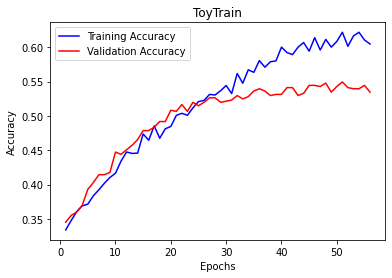

In [ ]:
pred_section_valve = fit_and_predict_section(model, 'valve', source = False)
pred_section_gearbox = fit_and_predict_section(model, 'gearbox', source = False)
pred_section_fan = fit_and_predict_section(model, 'fan', source = False)
pred_section_slider = fit_and_predict_section(model, 'slider', source = False)
pred_section_bearing = fit_and_predict_section(model, 'bearing', source = False)
pred_section_toycar = fit_and_predict_section(model, 'ToyCar', source = False)
pred_section_toytrain = fit_and_predict_section(model, 'ToyTrain', source = False)

In [ ]:
df_result_valve = build_result_df(pred_section_valve, 'valve', source = False)
df_result_gearbox = build_result_df(pred_section_gearbox, 'gearbox', source = False)
df_result_fan = build_result_df(pred_section_fan, 'fan', source = False)
df_result_slider = build_result_df(pred_section_slider, 'slider', source = False)
df_result_bearing = build_result_df(pred_section_bearing, 'bearing', source = False)
df_result_toycar = build_result_df(pred_section_toycar, 'ToyCar', source = False)
df_result_toytrain = build_result_df(pred_section_toytrain, 'ToyTrain', source = False)

df_all_results = pd.concat([df_result_valve, df_result_gearbox, df_result_fan, df_result_slider, \
                            df_result_bearing, df_result_toycar, df_result_toytrain], axis = 0)


In [ ]:
show_evaluations_section(df_result_valve)
show_evaluations_section(df_result_gearbox)
show_evaluations_section(df_result_fan)
show_evaluations_section(df_result_slider)
show_evaluations_section(df_result_bearing)
show_evaluations_section(df_result_toycar)
show_evaluations_section(df_result_toytrain)

***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  valve ***
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       200
           1       0.76      0.90      0.82       200
           2       0.94      0.82      0.88       200

    accuracy                           0.86       600
   macro avg       0.87      0.86      0.86       600
weighted avg       0.87      0.86      0.86       600



Pred    0    1    2
True               
0     171   25    4
1      14  180    6
2       3   33  164



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  gearbox ***
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       200
           1       0.83      0.95      0.89       200
           2       0.97      0.80      0.87       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



Pred    0    1    2
True               
0     200    0    0
1       4  191    5
2       3   38  159



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  fan ***
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       200
           1       0.86      0.97      0.92       200
           2       0.96      0.84      0.90       200

    accuracy                           0.93       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.93      0.93       600



Pred    0    1    2
True               
0     196    0    4
1       2  195    3
2       0   31  169



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  slider ***
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       200
           1       0.93      1.00      0.96       200
           2       0.95      0.97      0.96       200

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



Pred    0    1    2
True               
0     174   15   11
1       0  200    0
2       6    0  194



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  bearing ***
              precision    recall  f1-score   support

           0       0.79      0.36      0.50       200
           1       0.74      0.80      0.77       200
           2       0.64      0.94      0.76       200

    accuracy                           0.70       600
   macro avg       0.73      0.70      0.68       600
weighted avg       0.73      0.70      0.68       600



Pred   0    1    2
True              
0     73   53   74
1      9  160   31
2     10    2  188



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyCar ***
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       200
           1       0.31      0.27      0.29       200
           2       0.36      0.40      0.38       200

    accuracy                           0.45       600
   macro avg       0.44      0.45      0.44       600
weighted avg       0.44      0.45      0.44       600



Pred    0   1   2
True             
0     135  21  44
1      51  53  96
2      25  95  80



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyTrain ***
              precision    recall  f1-score   support

           0       0.50      0.58      0.54       200
           1       0.36      0.23      0.28       200
           2       0.42      0.51      0.46       200

    accuracy                           0.44       600
   macro avg       0.43      0.44      0.43       600
weighted avg       0.43      0.44      0.43       600



Pred    0   1    2
True              
0     117  36   47
1      64  46   90
2      52  47  101

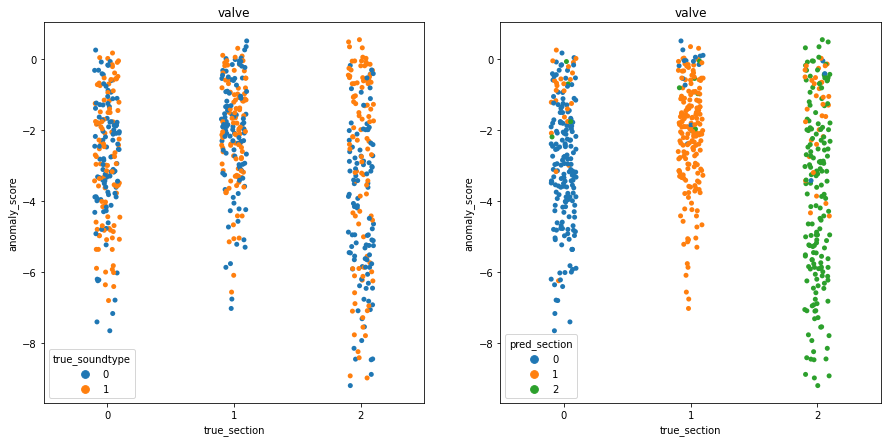

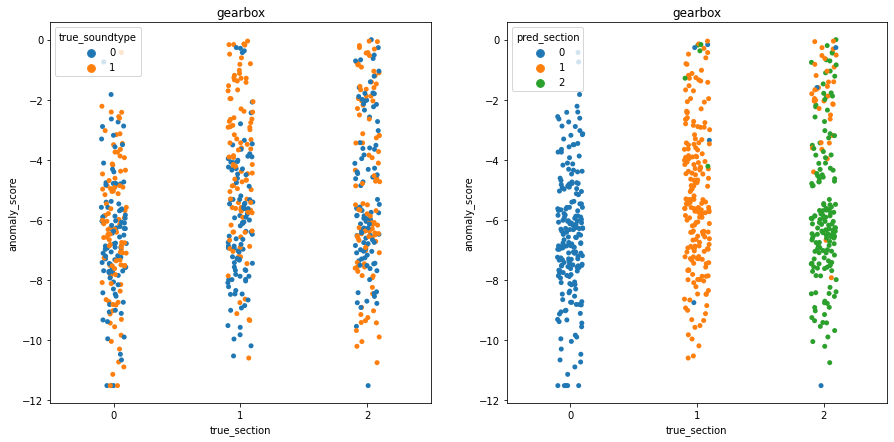

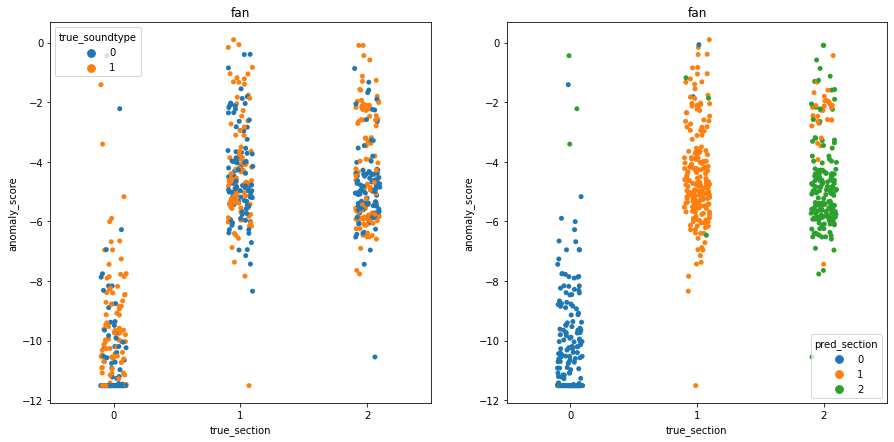

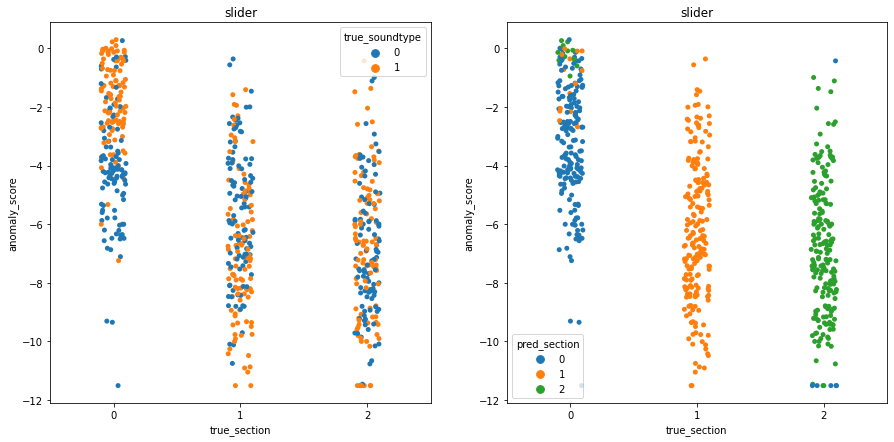

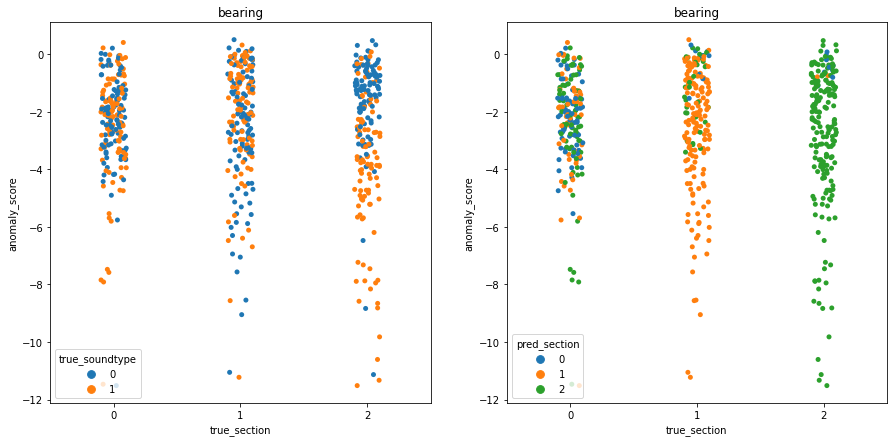

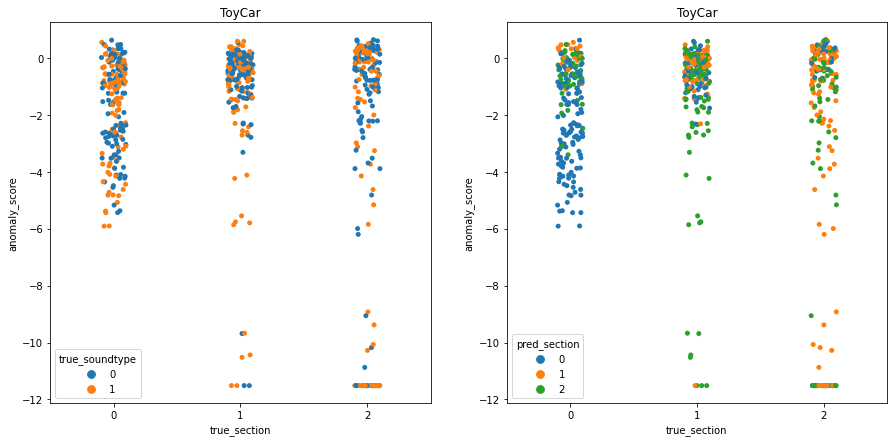

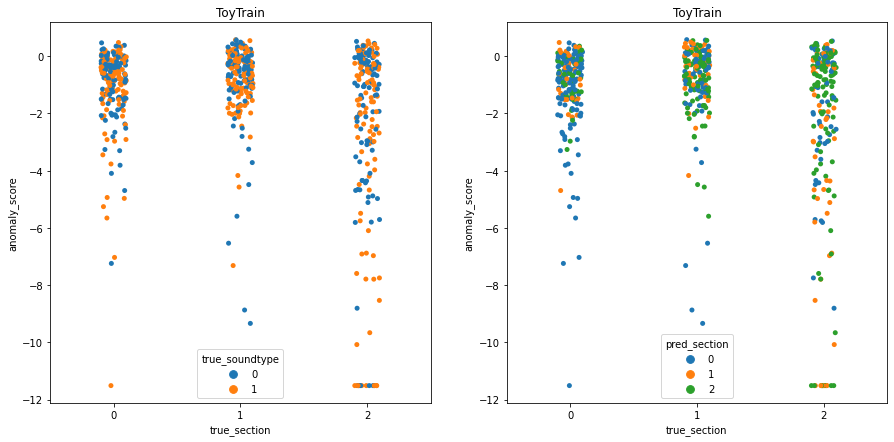

In [ ]:
plot_all_anomaly_scores(df_all_results)

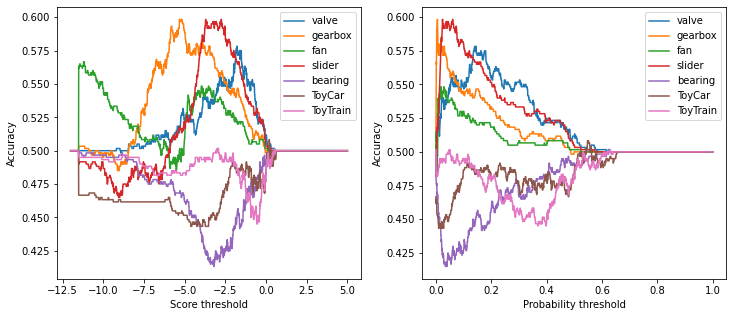

In [ ]:
plot_anomaly_acc_vs_threshold(df_all_results)

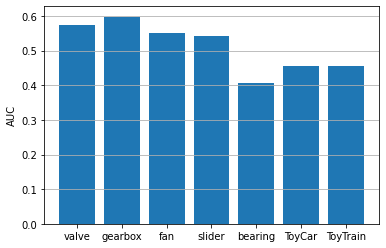

In [ ]:
compute_AUCs(df_all_results)

## Repeat with the best model by considering only data from the source domain

Clearly we should consider the best model per machine (ensemble method) but I've no time to do that. I choose the apparent best average model.

In [ ]:
model = Sequential([
        Input(shape = (128, 313, 1), name = "Input"),
        BatchNormalization(),
        Conv2D(filters = 32, kernel_size = (7, 7), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Conv2D(filters = 64, kernel_size = (3, 3), padding = 'valid', activation = 'relu'),
        MaxPooling2D(2),
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(3, activation='softmax')
        ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 128, 313, 1)      4         
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 307, 32)      1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 153, 32)      0         
 )                                                               
                                                                 
 batch_normalization_4 (Batc  (None, 61, 153, 32)      128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 151, 64)       18496     
                                                      

******* MACHINE =  valve*******
Epoch 1/100
75/75 [==============================] - 10s 114ms/step - loss: 0.8220 - accuracy: 0.6625 - val_loss: 4.6077 - val_accuracy: 0.3289 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 0.2238 - accuracy: 0.9292 - val_loss: 1.0300 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 3/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0624 - accuracy: 0.9846 - val_loss: 2.0593 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 4/100
75/75 [==============================] - 4s 48ms/step - loss: 0.0279 - accuracy: 0.9921 - val_loss: 0.9357 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 5/100
75/75 [==============================] - 5s 63ms/step - loss: 0.0197 - accuracy: 0.9950 - val_loss: 1.3217 - val_accuracy: 0.6776 - lr: 0.0010
Epoch 6/100
75/75 [==============================] - 3s 47ms/step - loss: 0.0191 - accuracy: 0.9967 - val_loss: 0.6086 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 7/100
75/75 [=================

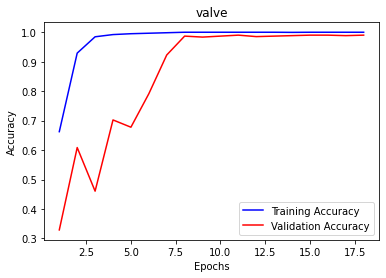

******* MACHINE =  gearbox*******
Epoch 1/100
75/75 [==============================] - 7s 89ms/step - loss: 0.2650 - accuracy: 0.9417 - val_loss: 1.9171 - val_accuracy: 0.5395 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 4s 48ms/step - loss: 0.0203 - accuracy: 0.9946 - val_loss: 0.8946 - val_accuracy: 0.6809 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 4s 50ms/step - loss: 0.0108 - accuracy: 0.9979 - val_loss: 0.0384 - val_accuracy: 0.9885 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 4s 55ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 0.9984 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9984 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 0.9984 - lr: 3.0000e-04
Epoch 7/100


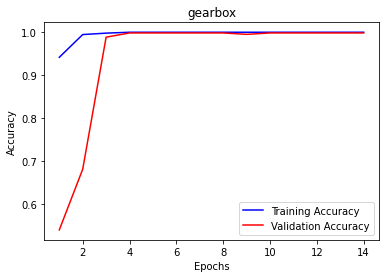

******* MACHINE =  fan*******
Epoch 1/100
75/75 [==============================] - 4s 50ms/step - loss: 0.0823 - accuracy: 0.9717 - val_loss: 0.1430 - val_accuracy: 0.9622 - lr: 9.0000e-05
Epoch 2/100
75/75 [==============================] - 3s 45ms/step - loss: 0.0208 - accuracy: 0.9942 - val_loss: 0.1363 - val_accuracy: 0.9605 - lr: 9.0000e-05
Epoch 3/100
75/75 [==============================] - 3s 47ms/step - loss: 0.0083 - accuracy: 0.9987 - val_loss: 0.0117 - val_accuracy: 0.9918 - lr: 9.0000e-05
Epoch 4/100
75/75 [==============================] - 4s 52ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 0.0018 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 5/100
75/75 [==============================] - 4s 47ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0033 - accuracy: 0.9996 - val_loss: 0.0017 - val_accuracy: 1.0000 - lr: 9.0000e-05
Epoch 7/100
75/7

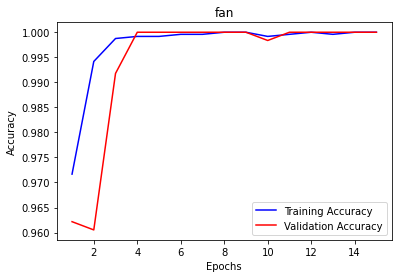

******* MACHINE =  slider*******
Epoch 1/100
75/75 [==============================] - 4s 50ms/step - loss: 0.6536 - accuracy: 0.8442 - val_loss: 0.8081 - val_accuracy: 0.6102 - lr: 2.7000e-05
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 0.1084 - accuracy: 0.9717 - val_loss: 0.1319 - val_accuracy: 0.9539 - lr: 2.7000e-05
Epoch 3/100
75/75 [==============================] - 4s 47ms/step - loss: 0.0588 - accuracy: 0.9879 - val_loss: 0.0347 - val_accuracy: 0.9918 - lr: 2.7000e-05
Epoch 4/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0335 - accuracy: 0.9942 - val_loss: 0.0687 - val_accuracy: 0.9901 - lr: 2.7000e-05
Epoch 5/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0251 - accuracy: 0.9967 - val_loss: 0.0626 - val_accuracy: 0.9918 - lr: 2.7000e-05
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 0.0260 - accuracy: 0.9950 - val_loss: 0.0677 - val_accuracy: 0.9984 - lr: 2.7000e-05
Epoch 7/100
7

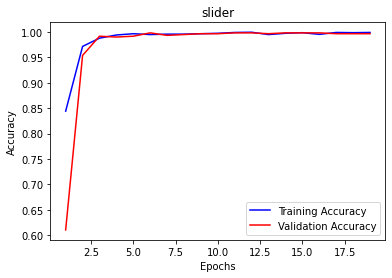

******* MACHINE =  bearing*******
Epoch 1/100
75/75 [==============================] - 4s 49ms/step - loss: 1.6497 - accuracy: 0.4758 - val_loss: 6.0928 - val_accuracy: 0.3322 - lr: 2.4300e-06
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 0.7114 - accuracy: 0.7533 - val_loss: 1.5820 - val_accuracy: 0.4342 - lr: 2.4300e-06
Epoch 3/100
75/75 [==============================] - 4s 47ms/step - loss: 0.4855 - accuracy: 0.8483 - val_loss: 0.5418 - val_accuracy: 0.8339 - lr: 2.4300e-06
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 0.3588 - accuracy: 0.8883 - val_loss: 0.3183 - val_accuracy: 0.9079 - lr: 2.4300e-06
Epoch 5/100
75/75 [==============================] - 4s 50ms/step - loss: 0.2946 - accuracy: 0.9187 - val_loss: 0.2607 - val_accuracy: 0.9375 - lr: 2.4300e-06
Epoch 6/100
75/75 [==============================] - 4s 47ms/step - loss: 0.2560 - accuracy: 0.9362 - val_loss: 0.2390 - val_accuracy: 0.9424 - lr: 2.4300e-06
Epoch 7/100


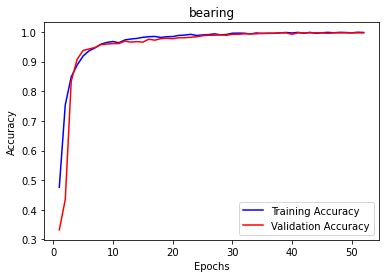

******* MACHINE =  ToyCar*******
Epoch 1/100
75/75 [==============================] - 4s 49ms/step - loss: 2.4148 - accuracy: 0.2333 - val_loss: 306.4537 - val_accuracy: 0.3438 - lr: 2.1870e-07
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 2.1819 - accuracy: 0.2537 - val_loss: 30.8707 - val_accuracy: 0.3618 - lr: 2.1870e-07
Epoch 3/100
75/75 [==============================] - 3s 47ms/step - loss: 2.0664 - accuracy: 0.2683 - val_loss: 3.3577 - val_accuracy: 0.3586 - lr: 2.1870e-07
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 1.9361 - accuracy: 0.2596 - val_loss: 1.9745 - val_accuracy: 0.3043 - lr: 2.1870e-07
Epoch 5/100
75/75 [==============================] - 4s 47ms/step - loss: 1.8528 - accuracy: 0.2829 - val_loss: 1.9012 - val_accuracy: 0.2845 - lr: 2.1870e-07
Epoch 6/100
75/75 [==============================] - 4s 47ms/step - loss: 1.7910 - accuracy: 0.2846 - val_loss: 1.8453 - val_accuracy: 0.2911 - lr: 2.1870e-07
Epoch 7/10

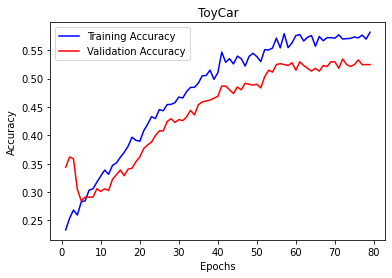

******* MACHINE =  ToyTrain*******
Epoch 1/100
75/75 [==============================] - 4s 48ms/step - loss: 2.2767 - accuracy: 0.3133 - val_loss: 16.5053 - val_accuracy: 0.3109 - lr: 5.9049e-09
Epoch 2/100
75/75 [==============================] - 4s 47ms/step - loss: 2.2893 - accuracy: 0.3158 - val_loss: 4.6325 - val_accuracy: 0.3174 - lr: 5.9049e-09
Epoch 3/100
75/75 [==============================] - 4s 47ms/step - loss: 2.2736 - accuracy: 0.3179 - val_loss: 2.7680 - val_accuracy: 0.2993 - lr: 5.9049e-09
Epoch 4/100
75/75 [==============================] - 4s 47ms/step - loss: 2.2646 - accuracy: 0.3192 - val_loss: 2.3860 - val_accuracy: 0.2961 - lr: 5.9049e-09
Epoch 5/100
75/75 [==============================] - 3s 47ms/step - loss: 2.2899 - accuracy: 0.3113 - val_loss: 2.3100 - val_accuracy: 0.3092 - lr: 5.9049e-09
Epoch 6/100
75/75 [==============================] - 3s 46ms/step - loss: 2.2687 - accuracy: 0.3196 - val_loss: 2.3109 - val_accuracy: 0.3010 - lr: 5.9049e-09
Epoch 7/10

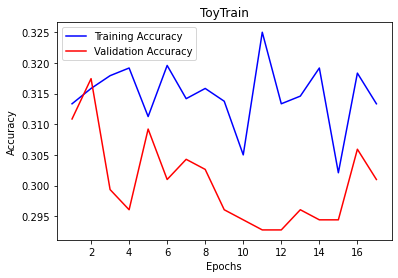

In [ ]:
pred_section_valve = fit_and_predict_section(model, 'valve', source = True)
pred_section_gearbox = fit_and_predict_section(model, 'gearbox', source = True)
pred_section_fan = fit_and_predict_section(model, 'fan', source = True)
pred_section_slider = fit_and_predict_section(model, 'slider', source = True)
pred_section_bearing = fit_and_predict_section(model, 'bearing', source = True)
pred_section_toycar = fit_and_predict_section(model, 'ToyCar', source = True)
pred_section_toytrain = fit_and_predict_section(model, 'ToyTrain', source = True)

In [ ]:
df_result_valve = build_result_df(pred_section_valve, 'valve', source = True)
df_result_gearbox = build_result_df(pred_section_gearbox, 'gearbox', source = True)
df_result_fan = build_result_df(pred_section_fan, 'fan', source = True)
df_result_slider = build_result_df(pred_section_slider, 'slider', source = True)
df_result_bearing = build_result_df(pred_section_bearing, 'bearing', source = True)
df_result_toycar = build_result_df(pred_section_toycar, 'ToyCar', source = True)
df_result_toytrain = build_result_df(pred_section_toytrain, 'ToyTrain', source = True)

df_all_results = pd.concat([df_result_valve, df_result_gearbox, df_result_fan, df_result_slider, \
                            df_result_bearing, df_result_toycar, df_result_toytrain], axis = 0)


In [ ]:
show_evaluations_section(df_result_valve)
show_evaluations_section(df_result_gearbox)
show_evaluations_section(df_result_fan)
show_evaluations_section(df_result_slider)
show_evaluations_section(df_result_bearing)
show_evaluations_section(df_result_toycar)
show_evaluations_section(df_result_toytrain)

***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  valve ***
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       100
           1       0.64      0.99      0.78       100
           2       1.00      0.64      0.78       100

    accuracy                           0.81       300
   macro avg       0.88      0.81      0.82       300
weighted avg       0.88      0.81      0.82       300



Pred   0   1   2
True            
0     81  19   0
1      1  99   0
2      0  36  64



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  gearbox ***
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       100
           1       0.83      0.95      0.88       100
           2       0.99      0.83      0.90       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300



Pred   0   1   2
True            
0     97   3   0
1      4  95   1
2      0  17  83



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  fan ***
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       0.87      0.98      0.92       100
           2       1.00      0.85      0.92       100

    accuracy                           0.94       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.95      0.94      0.94       300



Pred    0   1   2
True             
0     100   0   0
1       2  98   0
2       0  15  85



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  slider ***
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       100
           1       0.99      1.00      1.00       100
           2       1.00      0.98      0.99       100

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



Pred   0    1   2
True             
0     99    1   0
1      0  100   0
2      2    0  98



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  bearing ***
              precision    recall  f1-score   support

           0       0.59      0.19      0.29       100
           1       0.88      0.89      0.89       100
           2       0.56      0.94      0.70       100

    accuracy                           0.67       300
   macro avg       0.68      0.67      0.63       300
weighted avg       0.68      0.67      0.63       300



Pred   0   1   2
True            
0     19  12  69
1      7  89   4
2      6   0  94



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyCar ***
              precision    recall  f1-score   support

           0       0.58      0.73      0.65       100
           1       0.35      0.25      0.29       100
           2       0.48      0.49      0.49       100

    accuracy                           0.49       300
   macro avg       0.47      0.49      0.47       300
weighted avg       0.47      0.49      0.47       300



Pred   0   1   2
True            
0     73  12  15
1     37  25  38
2     16  35  49



***** EVALUATION OF SECTION CLASSIFICATION PER MACHINE ***** 
*** MACHINE =  ToyTrain ***
              precision    recall  f1-score   support

           0       0.30      0.41      0.35       100
           1       0.30      0.20      0.24       100
           2       0.29      0.28      0.28       100

    accuracy                           0.30       300
   macro avg       0.30      0.30      0.29       300
weighted avg       0.30      0.30      0.29       300



Pred   0   1   2
True            
0     41  23  36
1     47  20  33
2     48  24  28

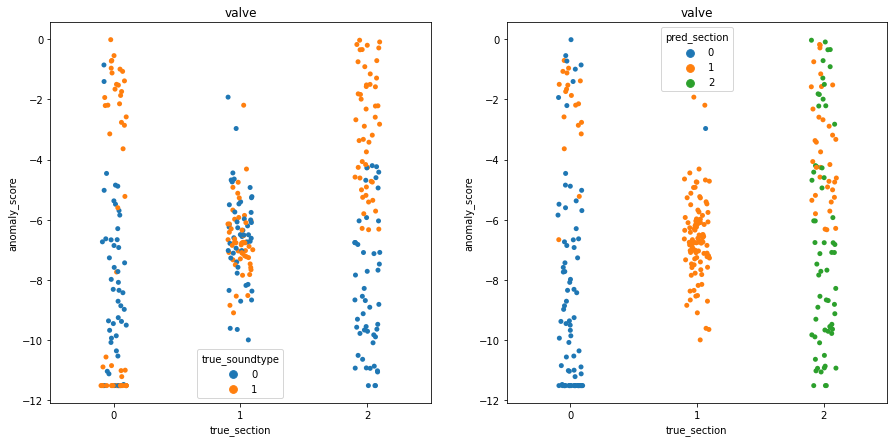

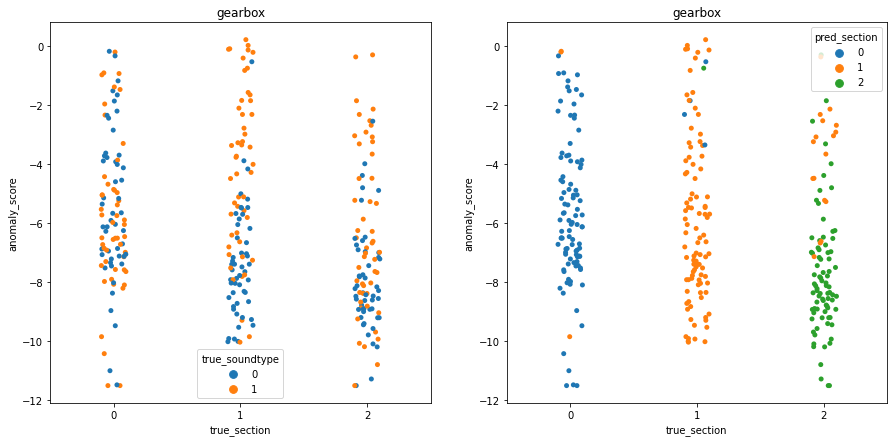

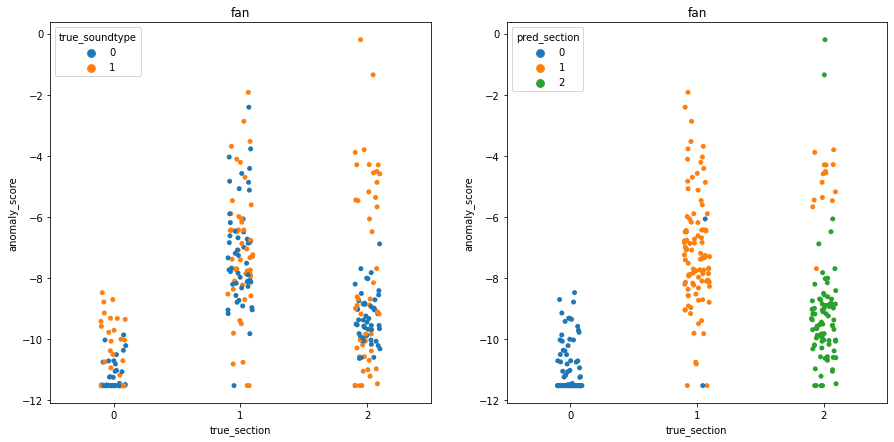

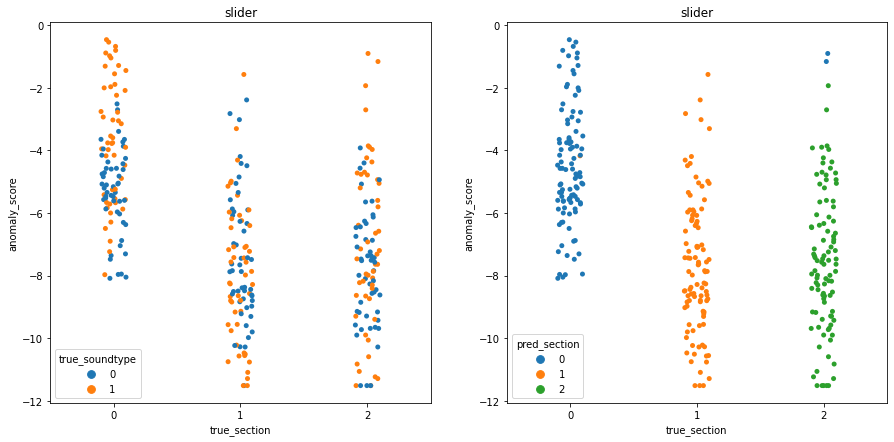

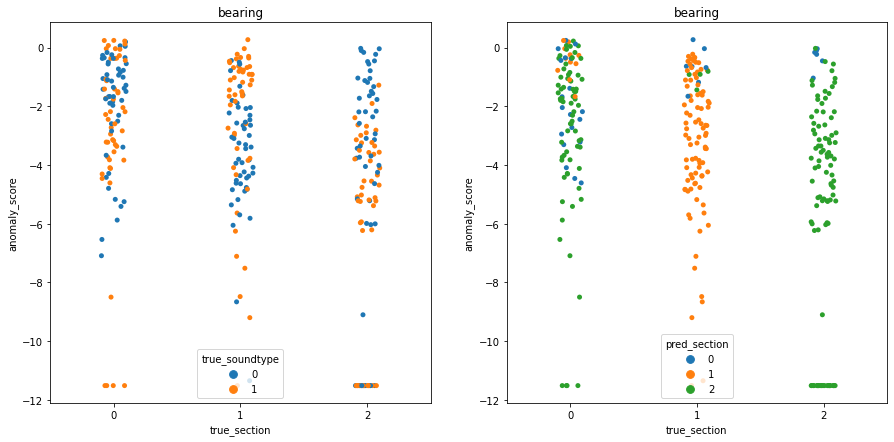

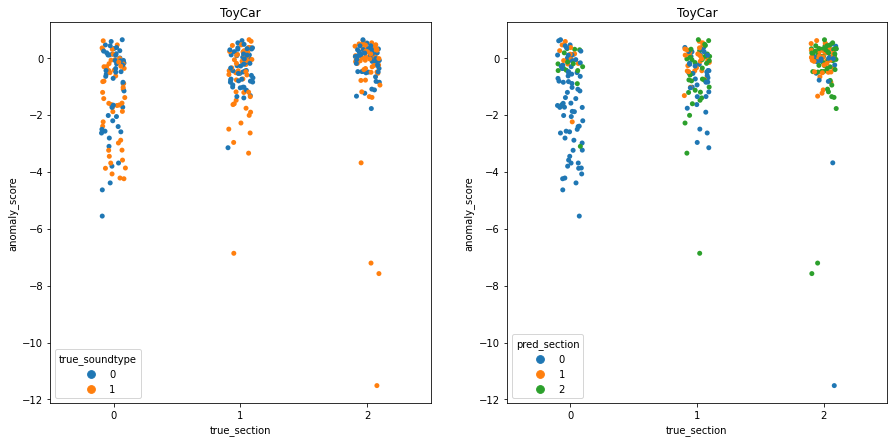

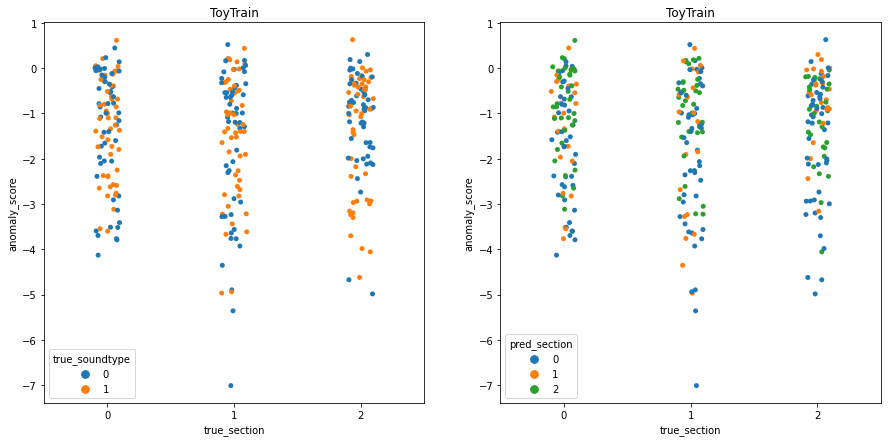

In [ ]:
plot_all_anomaly_scores(df_all_results)

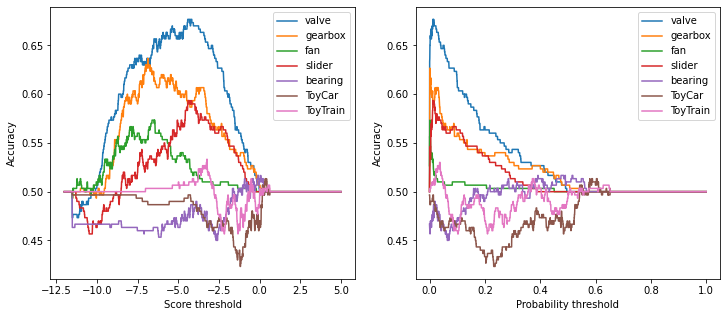

In [ ]:
plot_anomaly_acc_vs_threshold(df_all_results)

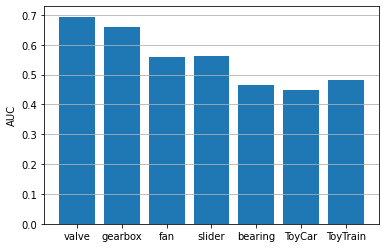

In [ ]:
compute_AUCs(df_all_results)

I'm surprised. This is not better by considering only data from the source domain.